In [140]:
import pandas as pd
import numpy as np
import math
import seaborn as sn
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from pyproj import CRS

# define all important function here

In [186]:
def AASHTO_AADT(cdata):
    """
    Compute Monthly and Annual Average Daily Traffic (MADT and AADT)
    using AASHTO methodology from hourly traffic count data.

    Parameters:
        cdata (pd.DataFrame): DataFrame with traffic count data including columns:
            - 'Loc_id', 'District', 'Intersection', 'year', 'month', 'Day', 'Date',
              'Count_Type', 'Count', 'hour', 'date', 'long_term', 'Site_Group'

    Returns:
        tuple:
            - AADT (pd.DataFrame): Annual Average Daily Traffic per location/year
            - num_deno_MADT (pd.DataFrame): Monthly Average Daily Traffic (MADT)
    """

    # Validate input type
    if not isinstance(cdata, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")

    # Required columns
    required_cols = {
        'site_name', 'year', 'month', 'Day', 'Date',
        'Count', 'hour', 'long_term', 'stratum'
    }
    missing_cols = required_cols - set(cdata.columns)
    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    # Ensure 'Count' is numeric
    if not pd.api.types.is_numeric_dtype(cdata['Count']):
        raise ValueError("'Count' column must be numeric")

    # Convert 'Date' to datetime
    cdata['Date'] = pd.to_datetime(cdata['Date'])

    # Hourly average by weekday
    cdata_hourly_ave = (
        cdata.groupby([
            'site_name', 'stratum',
            'year', 'month', 'Day', 'hour'
        ])[['Count']]
        .mean()
        .reset_index()
    )

    # Sum hourly averages to get daily totals (per day-of-week)
    cdata_daily_total = (
        cdata_hourly_ave.groupby([
            'site_name', 'stratum',
            'year', 'month', 'Day'
        ])[['Count']]
        .sum()
        .reset_index()
    )

    # Actual daily totals from raw data (to count days)
    cdata_daily = (
        cdata.groupby([
            'site_name', 'stratum',
            'year', 'month', 'Day', 'Date'
        ])[['Count']]
        .sum()
        .reset_index()
    )

    # Count number of each weekday in each month
    cdata_dcount = (
        cdata_daily.groupby([
            'site_name', 'stratum',
            'year', 'month', 'Day'
        ])
        .size()
        .reset_index(name='Wjm')
    )

    # Merge daily totals with weekday counts
    cdata_daily_total_wt = pd.merge(
        cdata_daily_total,
        cdata_dcount,
        on=['site_name', 'stratum', 'year', 'month', 'Day'],
        how='inner'
    )

    # Weighted totals
    cdata_daily_total_wt['wt_count'] = cdata_daily_total_wt['Count'] * cdata_daily_total_wt['Wjm']

    # Monthly aggregation
    MADT = (
        cdata_daily_total_wt.groupby([
            'site_name', 'stratum', 'year', 'month'
        ])[['wt_count', 'Wjm']]
        .sum()
        .reset_index()
        .rename(columns={'Wjm': 'dm'})
    )

    # Compute MADT
    MADT['MADT'] = (
        MADT['wt_count'] / MADT['dm']
    ).round(0).astype('int64')

    # Count number of days per year (for AADT denominator)
    day_count = (
        MADT.groupby([
            'site_name', 'stratum', 'year'
        ])['dm']
        .sum()
        .reset_index()
        .rename(columns={'dm': 'days_Ct'})
    )

    # Annual weighted total (AADT numerator)
    deno_AADT = (
        MADT.groupby([
            'site_name', 'stratum', 'year'
        ])[['wt_count']]
        .sum()
        .reset_index()
    )

    # Merge numerator and denominator
    AADT = pd.merge(
        deno_AADT,
        day_count,
        on=['site_name', 'stratum', 'year'],
        how='inner'
    )

    # Compute AADT
    AADT['AADT'] = (AADT['wt_count'] / AADT['days_Ct']).round(0).astype('int64')

    return AADT, MADT


In [142]:
def calculate_error_metrics(df, obs_col='Observed_AADT', imp_col='Imputed_AADT'):
    """
    Calculate MAPE, APE, RMSE, and R2 between observed and imputed AADT.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing observed and imputed columns
        obs_col (str): Name of the observed values column
        imp_col (str): Name of the imputed values column

    Returns:
        dict: A dictionary with MAPE, RMSE, R2, and a DataFrame with APE added
    """
    # Avoid division by zero for MAPE
    df = df.copy()
    df['APE'] = np.abs((df[obs_col] - df[imp_col]) / df[obs_col]) * 100
    mape = df['APE'].mean()
    
    rmse = mean_squared_error(df[obs_col], df[imp_col], squared=False)
    r2 = r2_score(df[obs_col], df[imp_col])

    return {
        'MAPE': round(mape, 2),
        'RMSE': round(rmse, 2),
        'R2': round(r2, 4),
        'data_with_APE': df
    }

In [143]:
def compute_metrics(group):
    y_true = group['Observed_AADT']
    y_pred = group['Imputed_AADT']
    
    # Skip empty or all-zero observed groups
    if len(y_true) == 0 or (y_true == 0).all():
        return pd.Series({'MAPE': np.nan, 'RMSE': np.nan, 'R2': np.nan})
    
    return pd.Series({
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)*100,
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'R2': r2_score(y_true, y_pred)
    })

In [144]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

## Task1: Use Metadata to classify the sites to Mountain,non_mountain, rural, urbana and suburban

In [145]:
# read the metda data
metadata=pd.read_csv('C:/Undergraduate Research/SEPARATION OF LATITUDE AND LONGITUDE FILTERED.csv')
metadata=metadata[['site_name','stratum']]
metadata.head()

site_name              stratum
0                                      BART AT SPIRE                 Path
1  Broadway Tunnel west of Hyde St Overpass EB (old)           Bike Route
2            Fell Street west of Scott WB (old site)  Separated Bike Lane
3                                LIWH: Borrego Trail                Trail
4                       LIWH: Serrano Trail (Gate 5)                Trail

In [146]:
metadata['site_name'].nunique()

295

# Task 2: Clean the Count Data

In [147]:
# read the hourly count data
hourly_count_raw_data=pd.read_csv('C:/Undergraduate Research/filtered_big_dataset_with_stratum.csv')
hourly_count_raw_data=hourly_count_raw_data[['date', 'isoDate', 'counts', 'status', 'id', 'site_name',
       'channel_name', 'latitude', 'longitude', 'direction']]
hourly_count_raw_data.head()

C:\Users\s160555\AppData\Local\Temp\ipykernel_22924\971228851.py:2: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_count_raw_data=pd.read_csv('C:/Undergraduate Research/filtered_big_dataset_with_stratum.csv')


date                   isoDate  counts  status  \
0  2022-01-01T00:00:00+0000  2022-01-01T00:00:00-0800     0.0     0.0   
1  2022-01-01T01:00:00+0000  2022-01-01T01:00:00-0800     0.0     0.0   
2  2022-01-01T02:00:00+0000  2022-01-01T02:00:00-0800     0.0     0.0   
3  2022-01-01T03:00:00+0000  2022-01-01T03:00:00-0800     0.0     0.0   
4  2022-01-01T04:00:00+0000  2022-01-01T04:00:00-0800     0.0     0.0   

          id      site_name                      channel_name  latitude  \
0  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
1  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
2  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
3  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
4  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   

   longitude  direction  
0 -122.45944          1  
1 -122.45944          1  
2 -122.45944          1  
3 -122.45944          1  
4 -122.45944          1

In [148]:
# collapse the date column
hourly_count_raw_data[[ "Date","Start Time1"]] = hourly_count_raw_data["isoDate"].str.split("T", expand = True)
hourly_count_raw_data[[ "Start Time","Time Zone"]] = hourly_count_raw_data["Start Time1"].str.split("-", expand = True)
hourly_count_raw_data.head()

date                   isoDate  counts  status  \
0  2022-01-01T00:00:00+0000  2022-01-01T00:00:00-0800     0.0     0.0   
1  2022-01-01T01:00:00+0000  2022-01-01T01:00:00-0800     0.0     0.0   
2  2022-01-01T02:00:00+0000  2022-01-01T02:00:00-0800     0.0     0.0   
3  2022-01-01T03:00:00+0000  2022-01-01T03:00:00-0800     0.0     0.0   
4  2022-01-01T04:00:00+0000  2022-01-01T04:00:00-0800     0.0     0.0   

          id      site_name                      channel_name  latitude  \
0  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
1  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
2  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
3  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   
4  103000671  BART AT SPIRE  BART at Spire- Bikes IN to Spire  37.79116   

   longitude  direction        Date    Start Time1 Start Time Time Zone  
0 -122.45944          1  2022-01-01  00:00:00-0800   00:00:00      0800  
1 -122.45944          1  2022-01-01  01:00:00-0800   01:00:00      0800  
2 -122.45944          1  2022-01-01  02:00:00-0800   02:00:00      0800  
3 -122.45944          1  2022-01-01  03:00:00-0800   03:00:00      0800  
4 -122.45944          1  2022-01-01  04:00:00-0800   04:00:00      0800

In [149]:
# combine directional count
hourly_count_raw_data1=pd.DataFrame({'counts': hourly_count_raw_data.groupby(['site_name','Date','Start Time','latitude', 'longitude'])['counts'].sum()}).reset_index()
hourly_count_raw_data1.head()

site_name        Date Start Time   latitude  \
0  (01) 11th St. Between Howard & Folsom  2022-01-01   00:00:00  37.772475   
1  (01) 11th St. Between Howard & Folsom  2022-01-01   01:00:00  37.772475   
2  (01) 11th St. Between Howard & Folsom  2022-01-01   02:00:00  37.772475   
3  (01) 11th St. Between Howard & Folsom  2022-01-01   03:00:00  37.772475   
4  (01) 11th St. Between Howard & Folsom  2022-01-01   04:00:00  37.772475   

    longitude  counts  
0 -122.414678     5.0  
1 -122.414678     6.0  
2 -122.414678     7.0  
3 -122.414678     2.0  
4 -122.414678     1.0

In [150]:
# Now join with metadata
hourly_count_raw_data2=pd.merge(hourly_count_raw_data1,metadata, on=['site_name'], how='inner')
hourly_count_raw_data2.shape

(1804354, 7)

## Clean the data

In [151]:
# Drop rows where site_name contains 'delete', 'old', or 'uninstalled' (case-insensitive)
hourly_count_raw_data3 = hourly_count_raw_data2[
    ~hourly_count_raw_data2["site_name"].str.contains("delete|old|uninstalled", case=False, na=False)
]
hourly_count_raw_data3.head()

site_name        Date Start Time   latitude  \
0  (01) 11th St. Between Howard & Folsom  2022-01-01   00:00:00  37.772475   
1  (01) 11th St. Between Howard & Folsom  2022-01-01   01:00:00  37.772475   
2  (01) 11th St. Between Howard & Folsom  2022-01-01   02:00:00  37.772475   
3  (01) 11th St. Between Howard & Folsom  2022-01-01   03:00:00  37.772475   
4  (01) 11th St. Between Howard & Folsom  2022-01-01   04:00:00  37.772475   

    longitude  counts stratum  
0 -122.414678     5.0    Path  
1 -122.414678     6.0    Path  
2 -122.414678     7.0    Path  
3 -122.414678     2.0    Path  
4 -122.414678     1.0    Path

In [152]:
hourly_count_raw_data3['Date'] = pd.to_datetime(hourly_count_raw_data3['Date'])
hourly_count_raw_data3["Start Time"] = pd.to_datetime(hourly_count_raw_data3["Start Time"], format="%H:%M:%S")
hourly_count_raw_data3['year'] =hourly_count_raw_data3['Date'].dt.year
# Month short name (Jan, Feb, etc.)
hourly_count_raw_data3["month"] = hourly_count_raw_data3["Date"].dt.strftime("%b")
# Day full name (Monday, Tuesday, etc.)
hourly_count_raw_data3["Day"] = hourly_count_raw_data3["Date"].dt.strftime("%A")
hourly_count_raw_data3['hour'] = hourly_count_raw_data3['Start Time'].dt.hour
hourly_count_raw_data3.head()

C:\Users\s160555\AppData\Local\Temp\ipykernel_22924\4096958731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_count_raw_data3['Date'] = pd.to_datetime(hourly_count_raw_data3['Date'])
C:\Users\s160555\AppData\Local\Temp\ipykernel_22924\4096958731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_count_raw_data3["Start Time"] = pd.to_datetime(hourly_count_raw_data3["Start Time"], format="%H:%M:%S")
C:\Users\s160555\AppData\Local\Temp\ipykernel_22924\4096958731.py:3: SettingWithCopyWarning

site_name       Date          Start Time  \
0  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 00:00:00   
1  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 01:00:00   
2  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 02:00:00   
3  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 03:00:00   
4  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 04:00:00   

    latitude   longitude  counts stratum  year month       Day  hour  
0  37.772475 -122.414678     5.0    Path  2022   Jan  Saturday     0  
1  37.772475 -122.414678     6.0    Path  2022   Jan  Saturday     1  
2  37.772475 -122.414678     7.0    Path  2022   Jan  Saturday     2  
3  37.772475 -122.414678     2.0    Path  2022   Jan  Saturday     3  
4  37.772475 -122.414678     1.0    Path  2022   Jan  Saturday     4

In [153]:
hourly_count_raw_data3.shape

(1725523, 11)

In [154]:
# consecutive zeros check out
consecutive_zeros_bike_data = hourly_count_raw_data3.groupby(['site_name', 'year', 'month']).filter(lambda x: (x['counts'].sum() == 0))
print("The data have " + f"{len(consecutive_zeros_bike_data)}" + " hours of counts where the sum for the entire month is 0.")

aggregated_data = consecutive_zeros_bike_data.groupby(['site_name','year', 'month']).agg(
    month_count_sum=('counts', 'sum'),
    num_counts_in_month=('counts', 'count')
).reset_index()

The data have 1118366 hours of counts where the sum for the entire month is 0.


In [155]:
# Filter out rows from bad sites or where month sum is = 0
hourly_total_count_clean_per_site = hourly_count_raw_data3.groupby(['site_name','year', 'month']).filter(
    lambda x: (x['counts'].sum() > 0))
print("After removing months where the sum for the entire month of available data was 0, the data have " + f"{hourly_total_count_raw_per_intersection['site_name'].nunique()}" + " unique count site names.")

After removing months where the sum for the entire month of available data was 0, the data have 189 unique count site names.


In [156]:
hourly_total_count_clean_per_site.shape

(607157, 11)

In [157]:
hourly_total_count_clean_per_site.head()

site_name       Date          Start Time  \
0  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 00:00:00   
1  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 01:00:00   
2  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 02:00:00   
3  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 03:00:00   
4  (01) 11th St. Between Howard & Folsom 2022-01-01 1900-01-01 04:00:00   

    latitude   longitude  counts stratum  year month       Day  hour  
0  37.772475 -122.414678     5.0    Path  2022   Jan  Saturday     0  
1  37.772475 -122.414678     6.0    Path  2022   Jan  Saturday     1  
2  37.772475 -122.414678     7.0    Path  2022   Jan  Saturday     2  
3  37.772475 -122.414678     2.0    Path  2022   Jan  Saturday     3  
4  37.772475 -122.414678     1.0    Path  2022   Jan  Saturday     4

In [158]:
# Step 1: Sort by time to ensure proper ordering for shift
hourly_total_count_clean_per_site.sort_values(
    by=['site_name', 'year', 'month', 'Day', 'Date', 'hour'],
    inplace=True
)

# Step 2: Calculate previous hour's count
hourly_total_count_clean_per_site['prev_hour_count'] = (
    hourly_total_count_clean_per_site
    .groupby(['site_name'])
    ['counts']
    .shift(1)
)

# Step 3: Flag large increases (>= 30x) from previous hour (if prev count > 15)
hourly_total_count_clean_per_site['flag'] = (
    (hourly_total_count_clean_per_site['counts'] >= 10 * hourly_total_count_clean_per_site['prev_hour_count']) &
    (hourly_total_count_clean_per_site['prev_hour_count'] > 10)
)

# Step 4: Separate flagged and unflagged rows
flagged_rows4 = hourly_total_count_clean_per_site[hourly_total_count_clean_per_site['flag']]
hourly_total_count_clean_per_site_flagged = hourly_total_count_clean_per_site[~hourly_total_count_clean_per_site['flag']]

# Optional: Display flagged anomalies
flagged_rows4

site_name       Date  \
121907      (14) Duboce Bike Path behind Safeway 2022-12-02   
140730  (18) Fell St. Between Scott & Divisadero 2022-01-25   
859389             Lakeside-Harrison Cycle Track 2022-02-11   
865269             Lakeside-Harrison Cycle Track 2022-10-14   

                Start Time   latitude   longitude  counts  \
121907 1900-01-01 00:00:00  37.769480 -122.427470  3945.0   
140730 1900-01-01 10:00:00  37.774200 -122.436295   762.0   
859389 1900-01-01 23:00:00  37.808444 -122.263378   280.0   
865269 1900-01-01 23:00:00  37.808444 -122.263378   509.0   

                    stratum  year month      Day  hour  prev_hour_count  flag  
121907                 Path  2022   Dec   Friday     0             18.0  True  
140730  Separated Bike Lane  2022   Jan  Tuesday    10             75.0  True  
859389  Separated Bike Lane  2022   Feb   Friday    23             18.0  True  
865269  Separated Bike Lane  2022   Oct   Friday    23             26.0  True

In [159]:
hourly_total_count_clean_per_site_flagged.shape

(607153, 13)

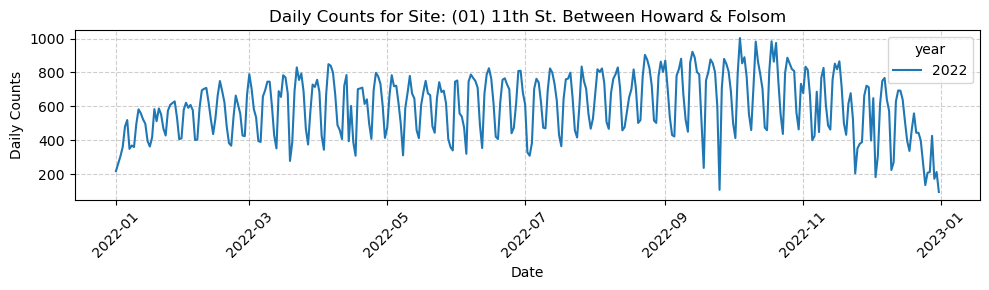

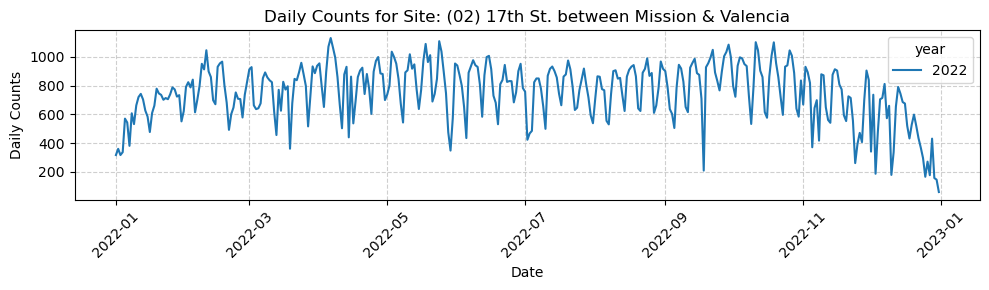

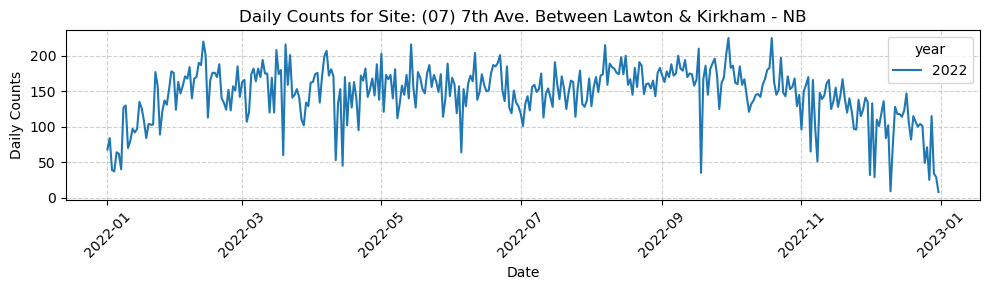

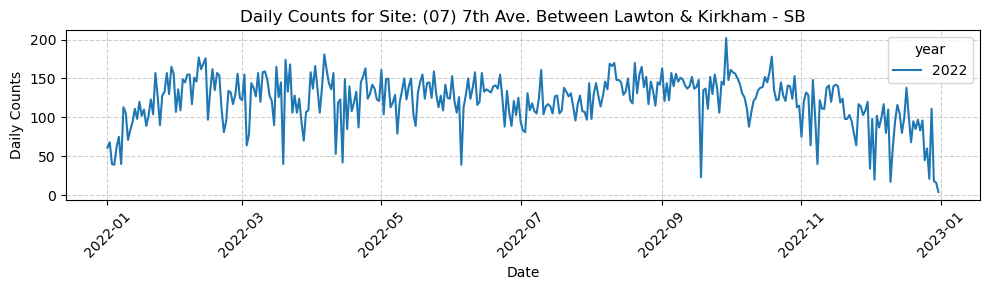

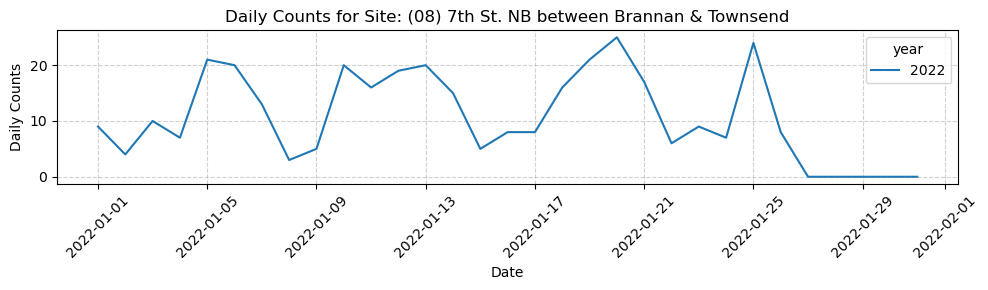

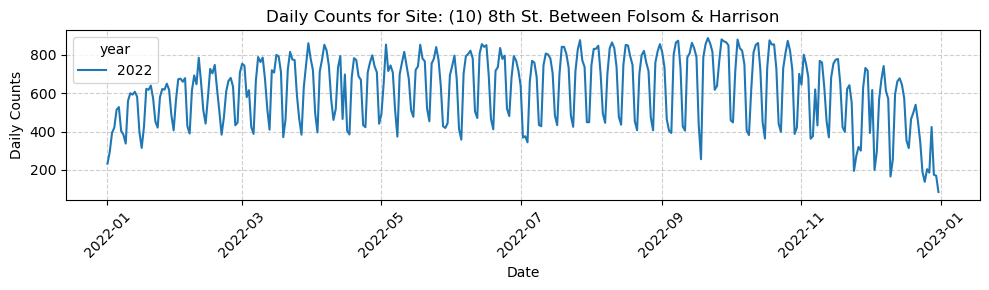

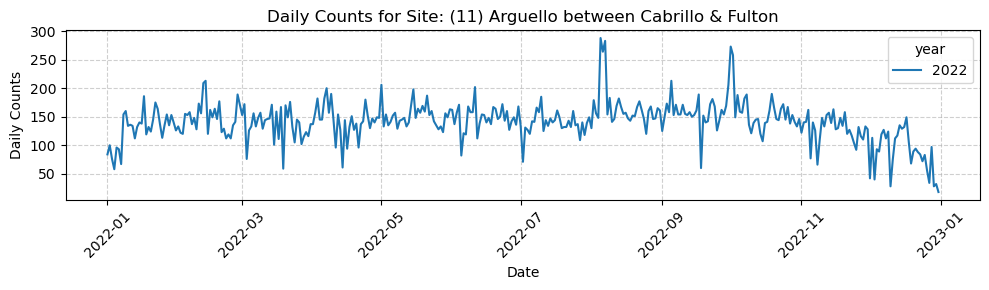

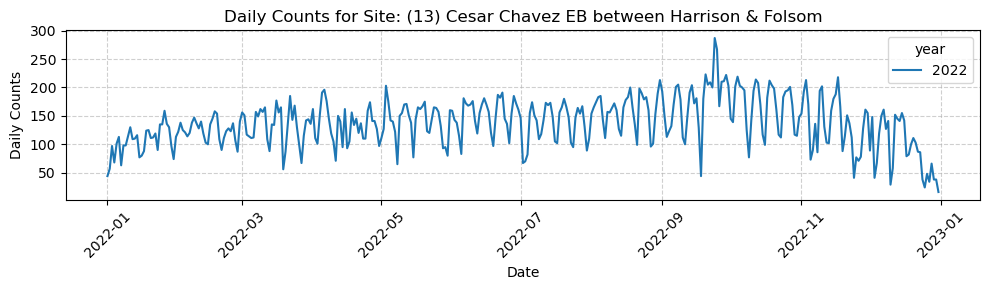

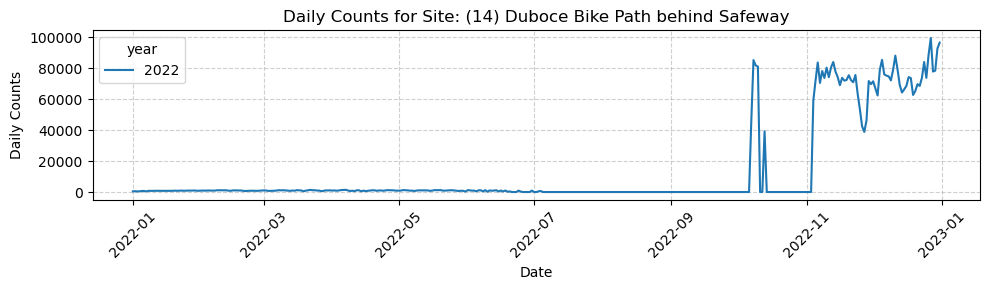

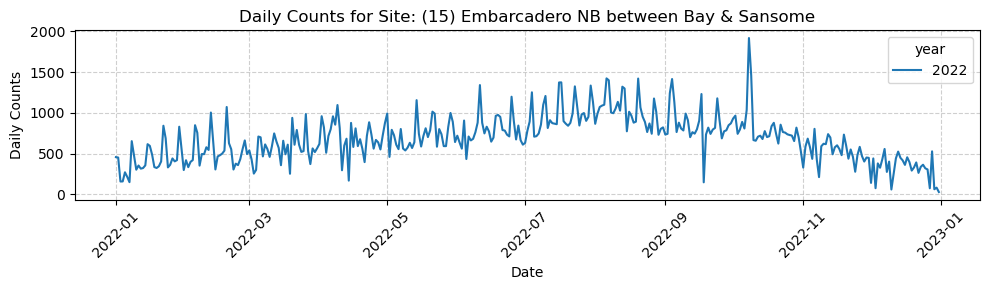

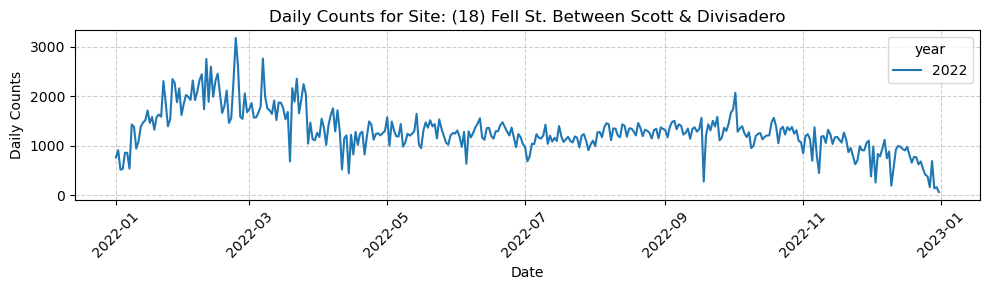

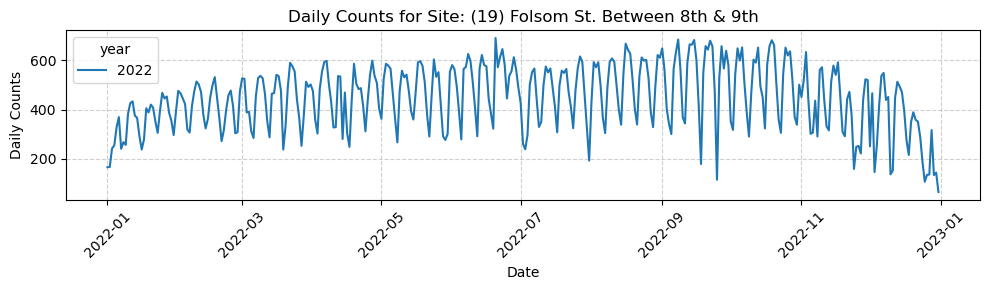

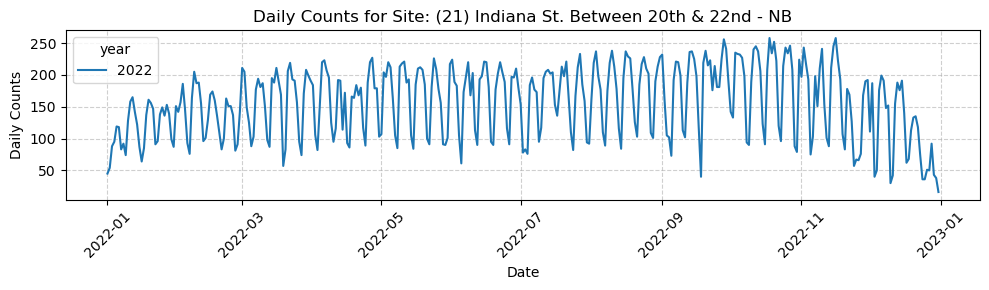

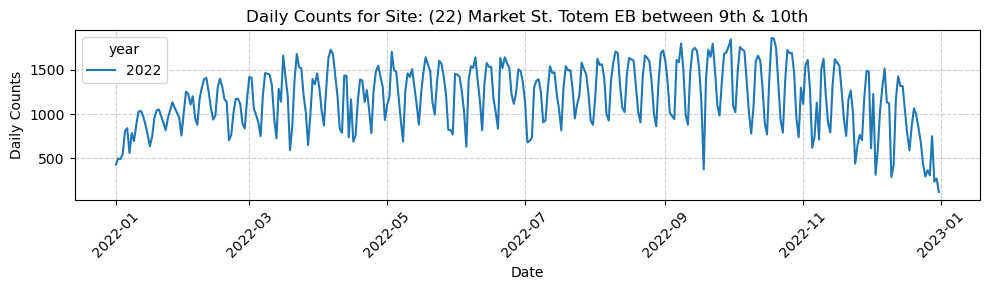

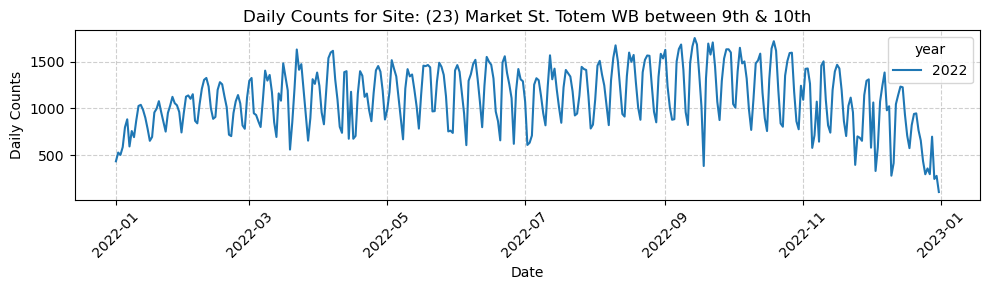

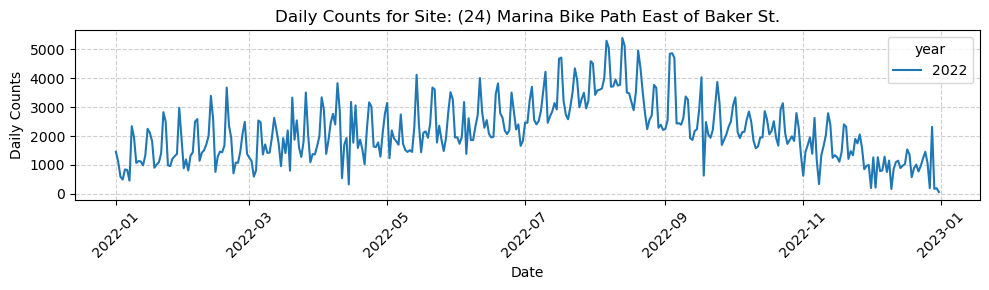

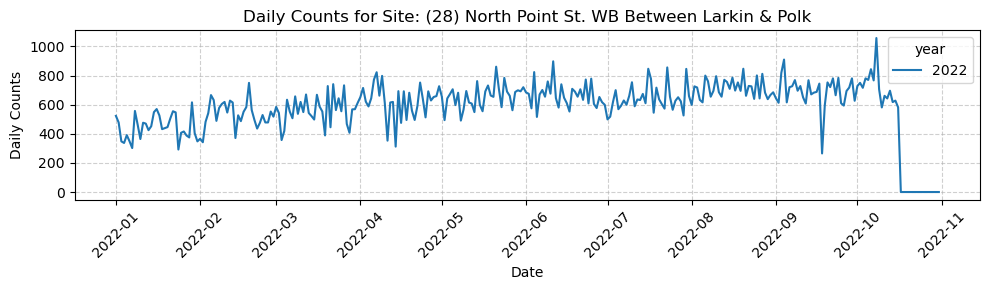

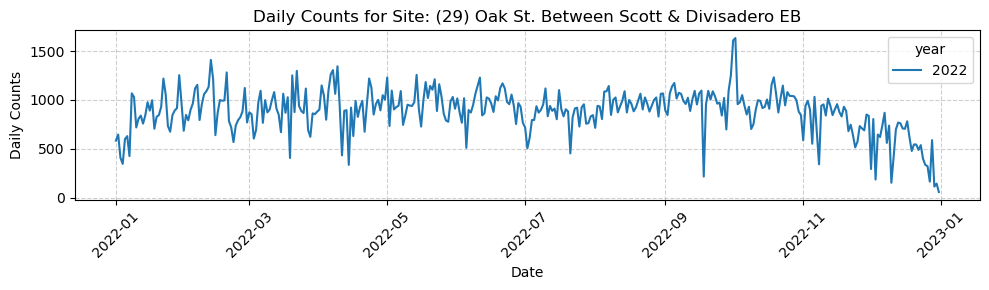

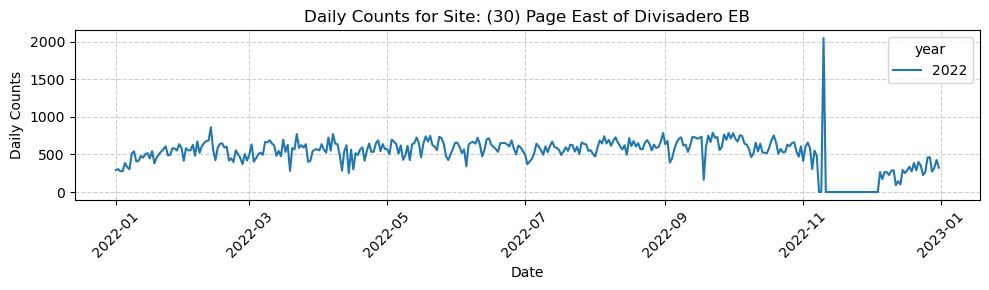

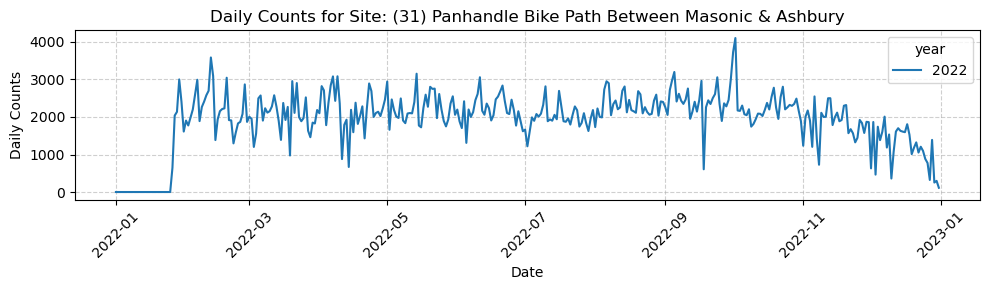

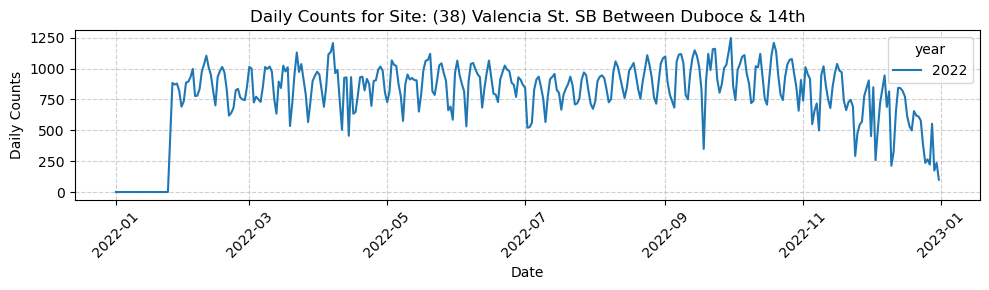

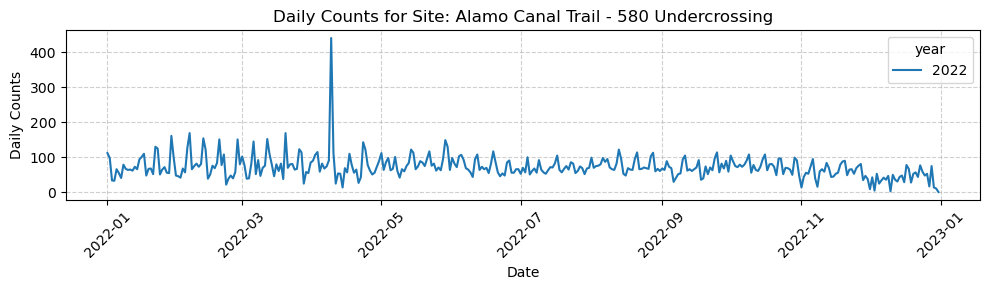

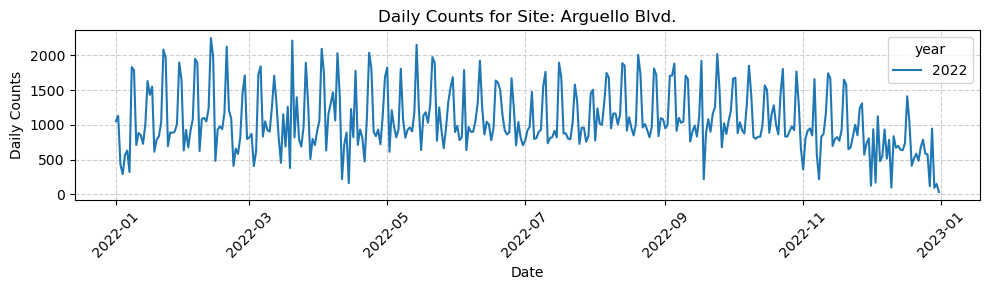

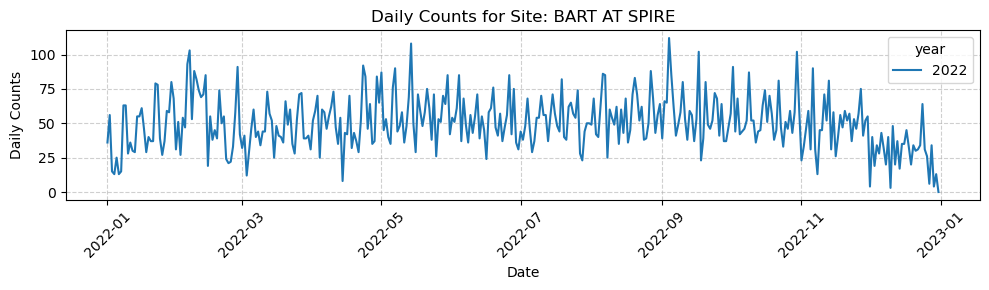

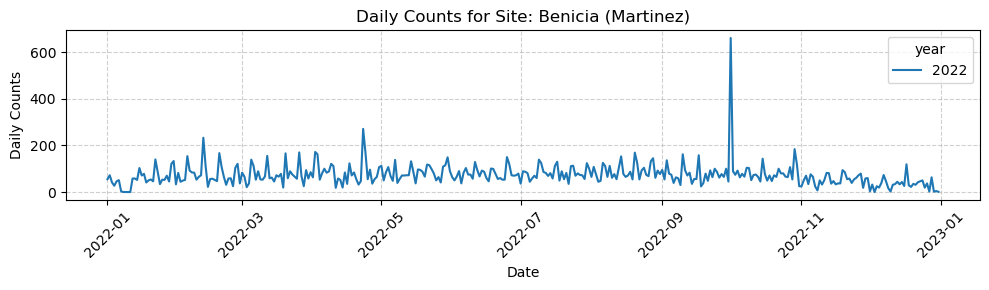

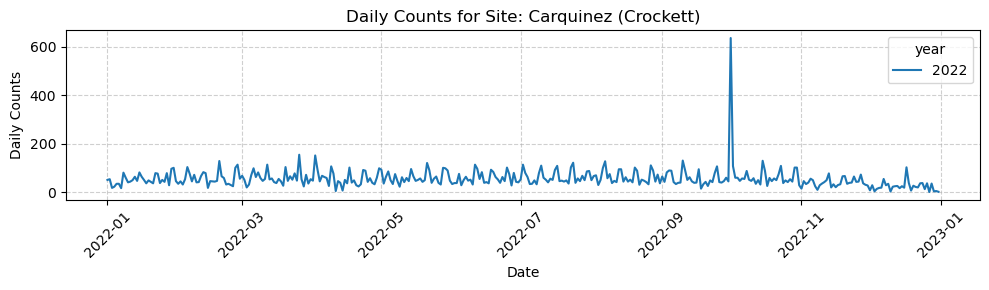

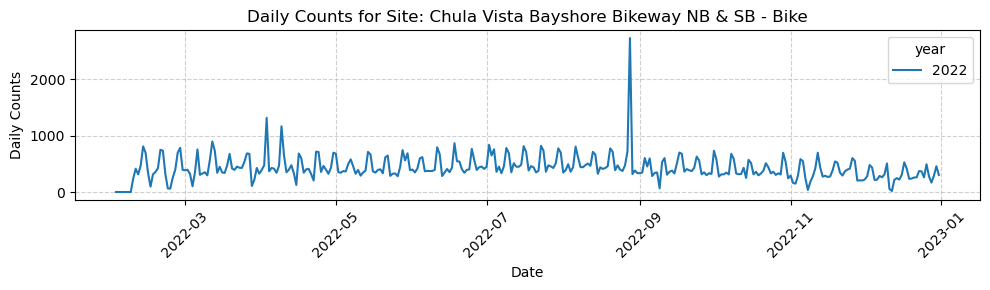

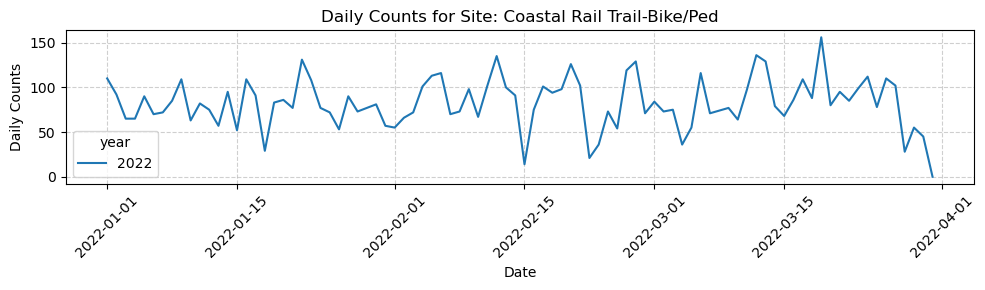

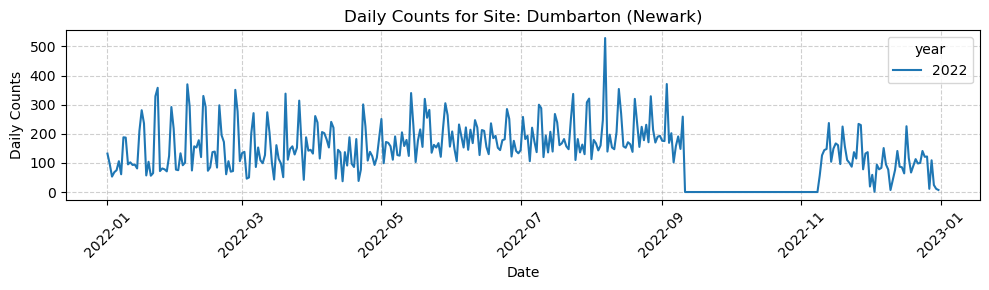

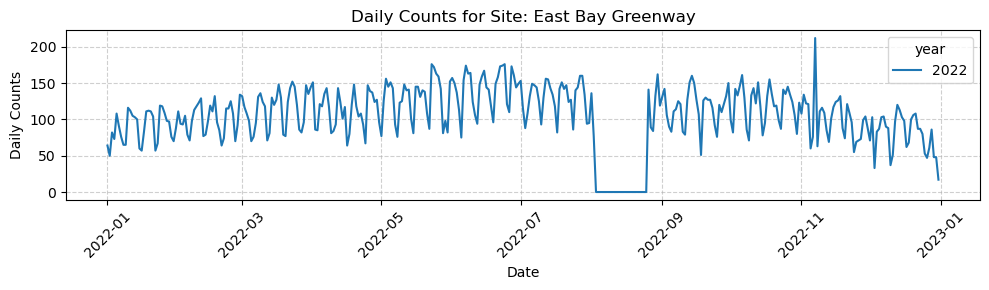

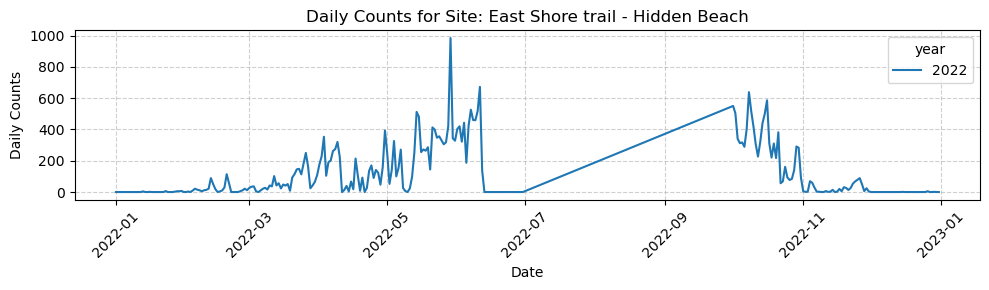

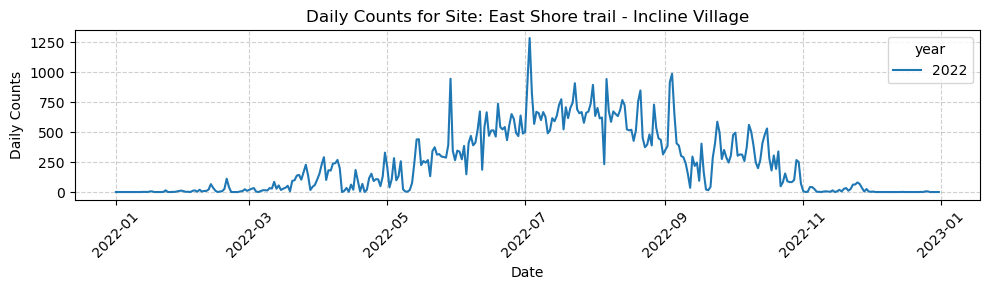

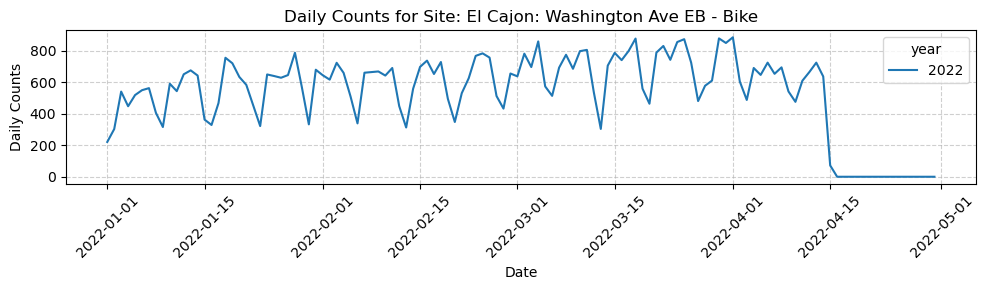

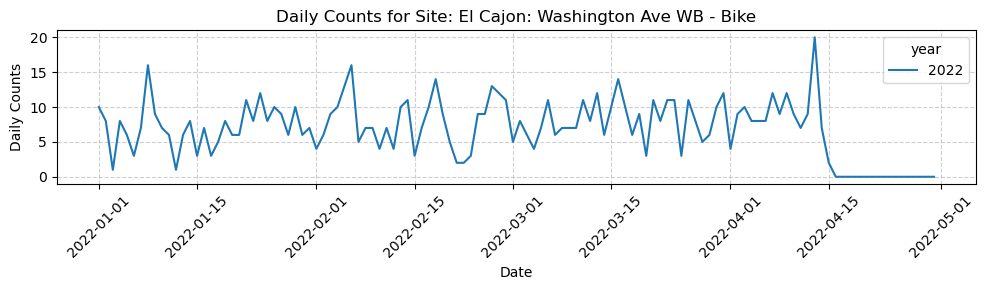

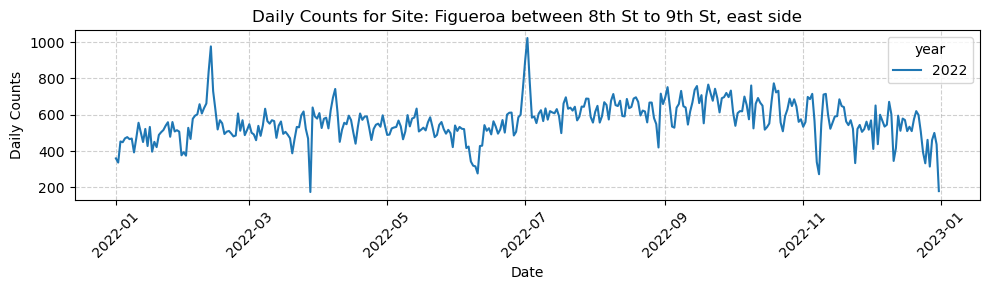

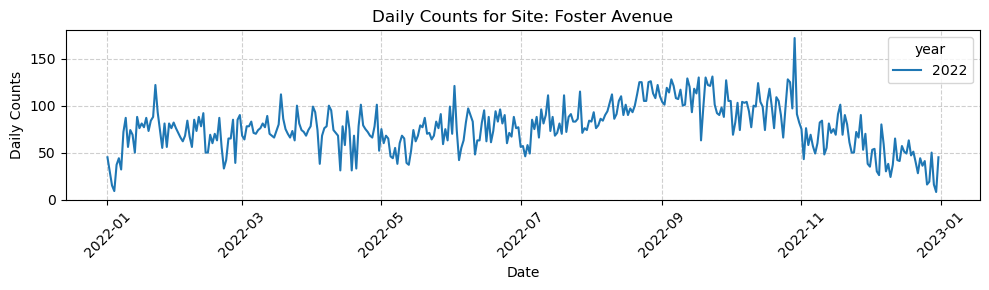

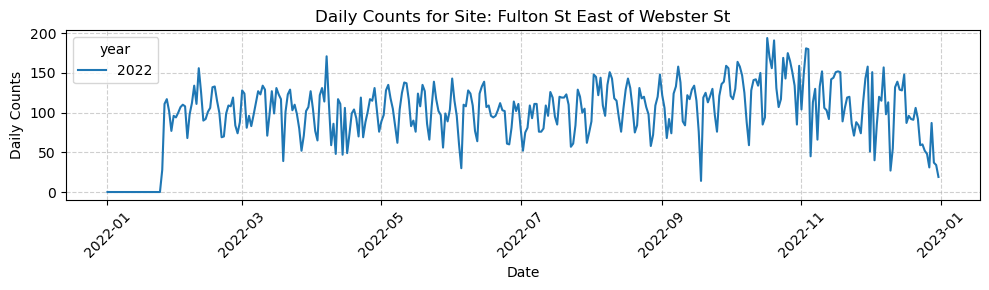

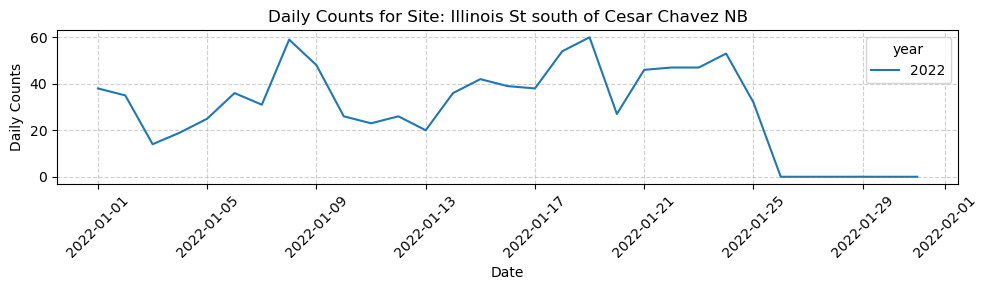

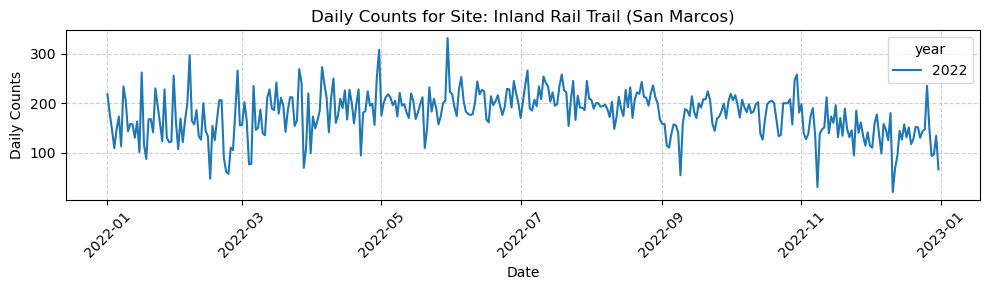

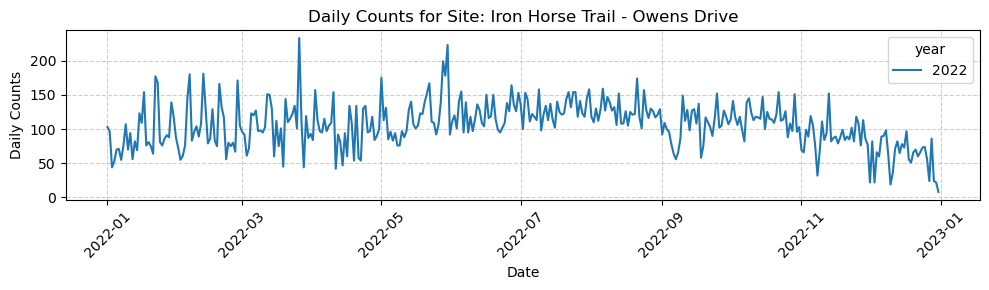

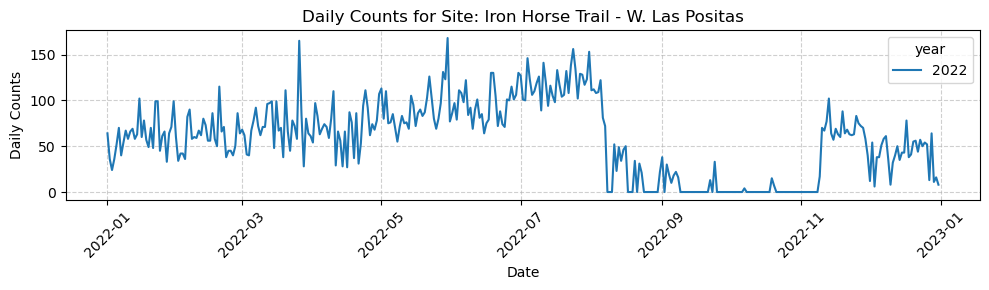

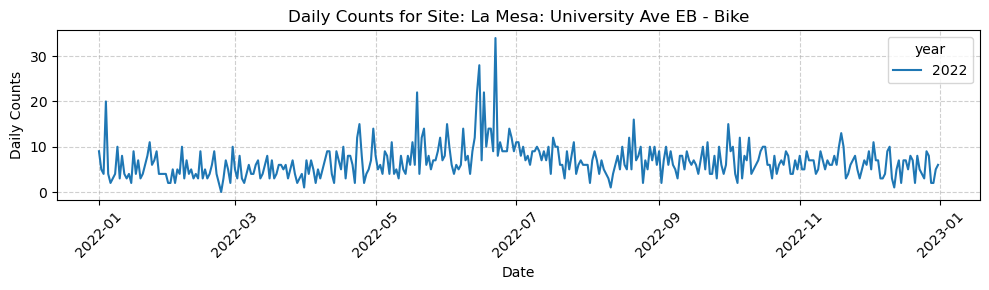

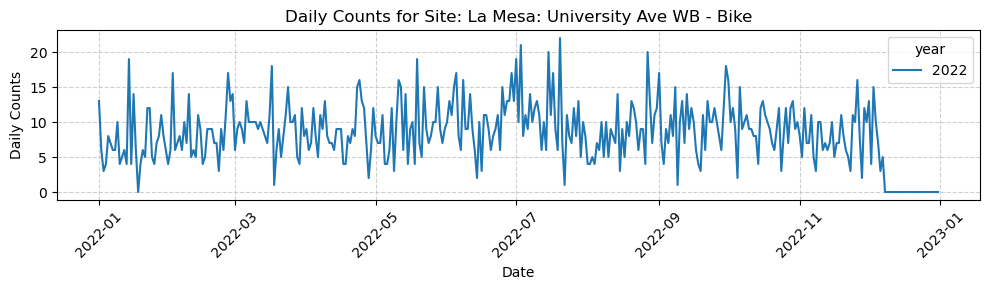

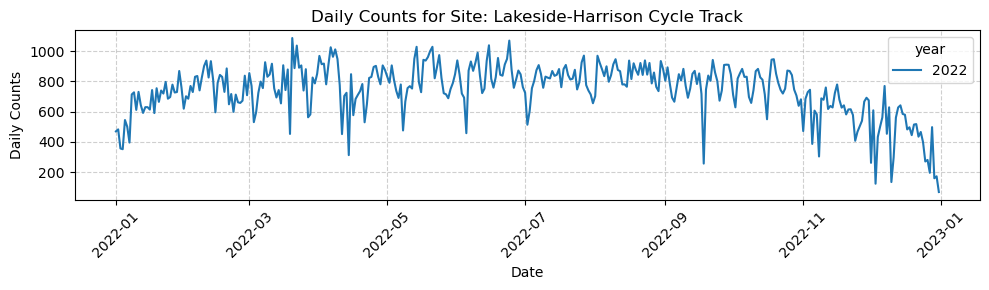

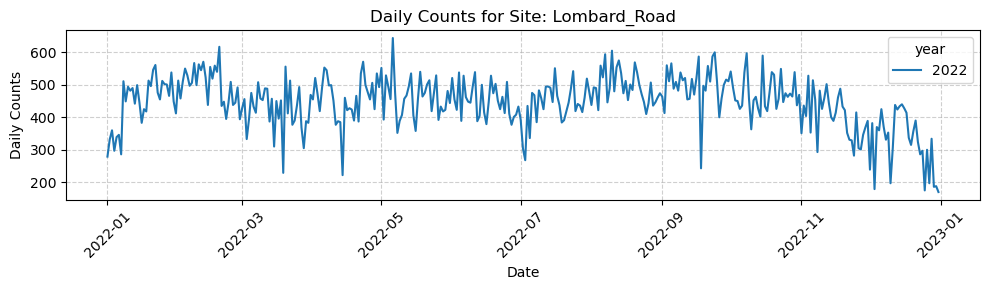

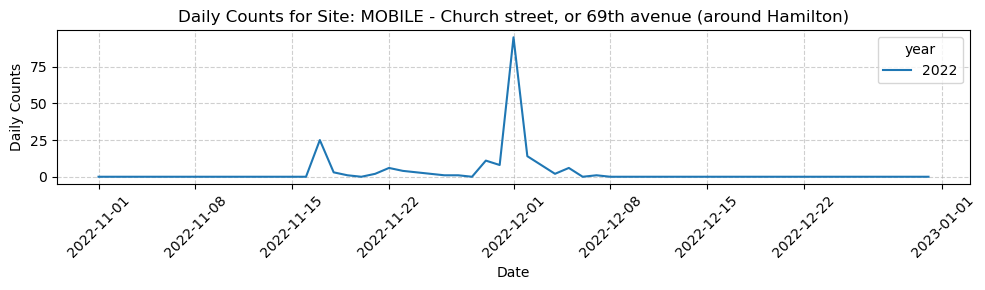

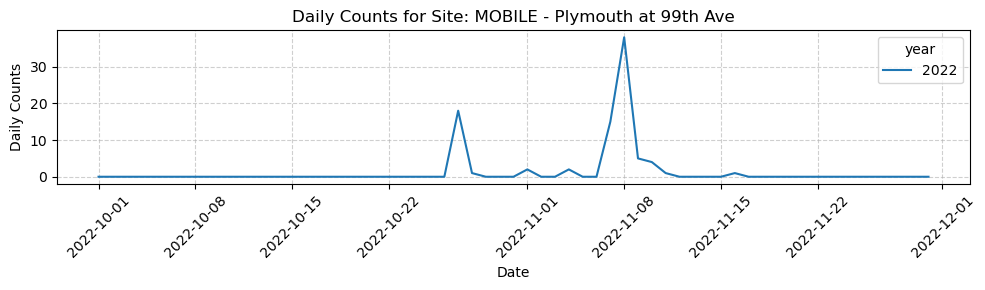

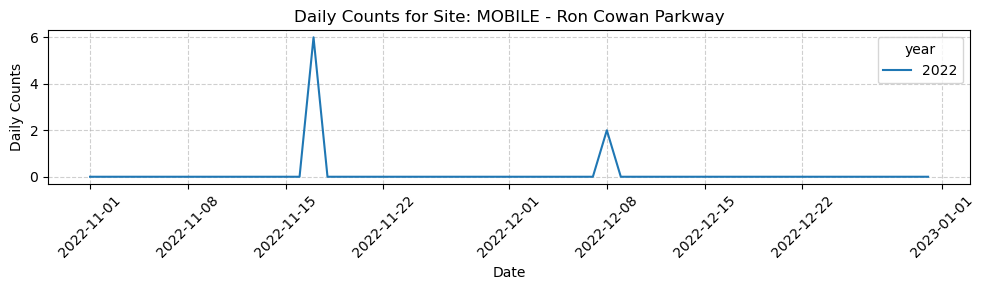

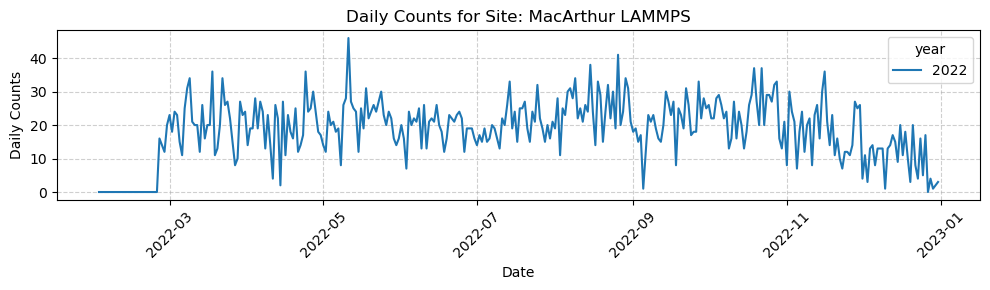

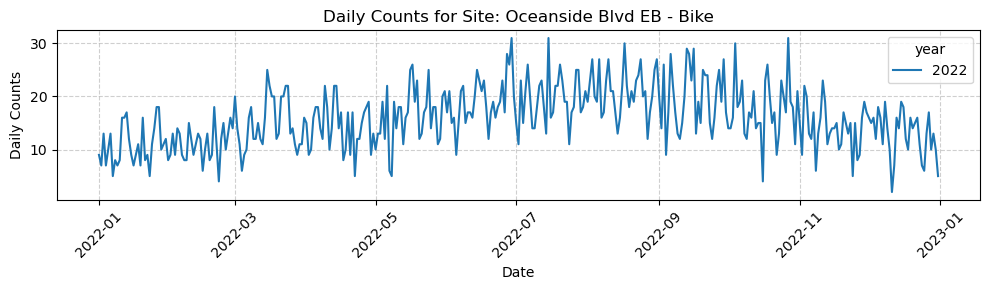

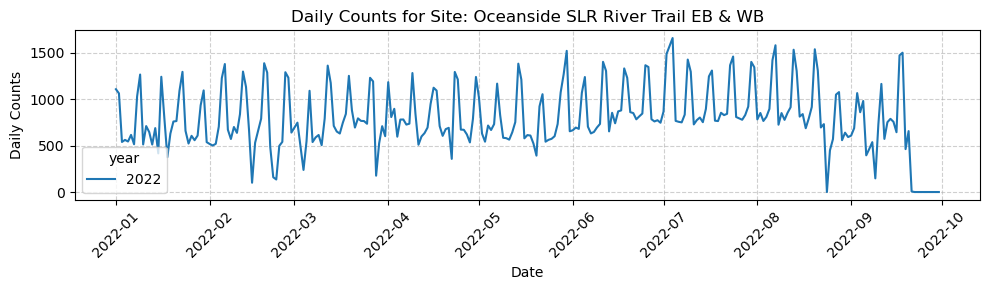

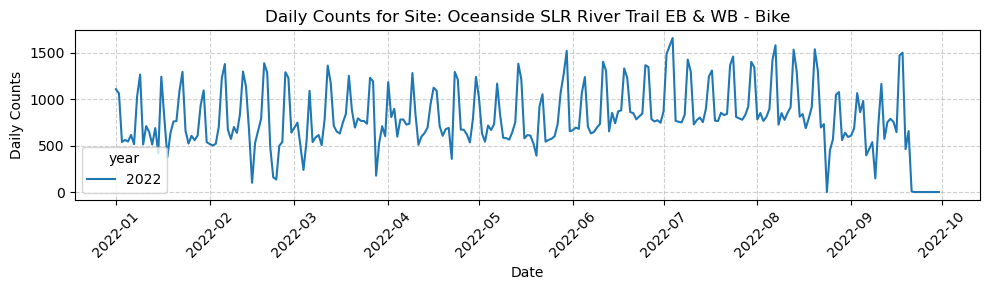

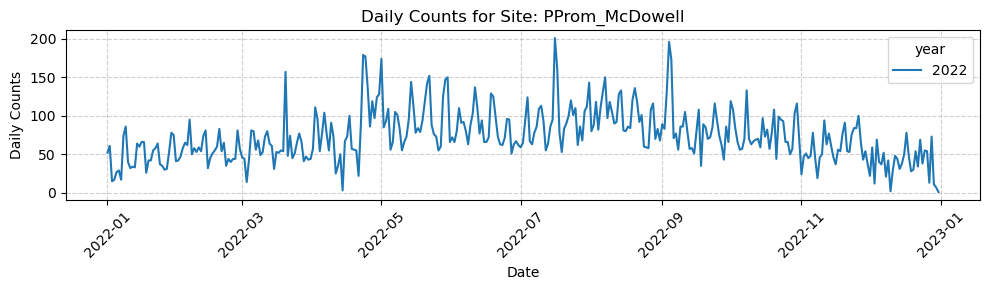

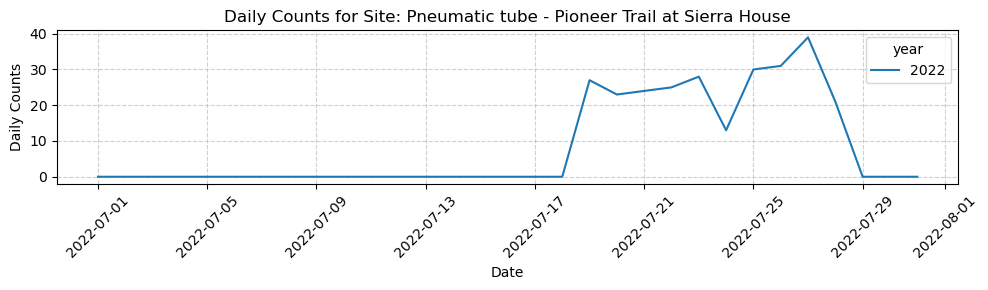

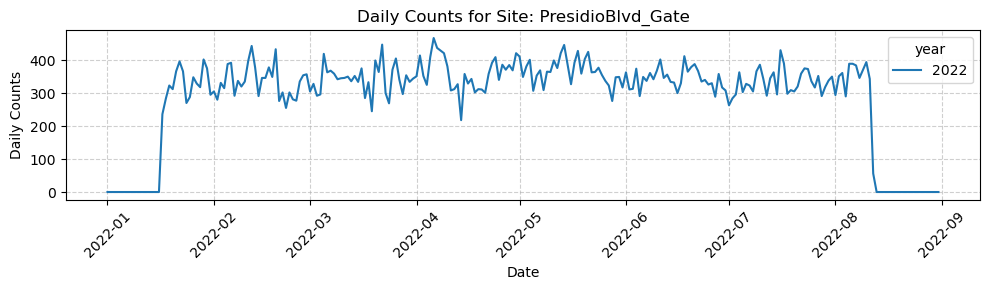

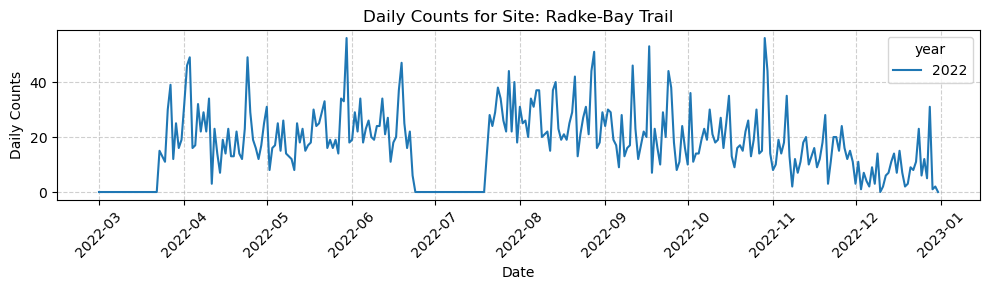

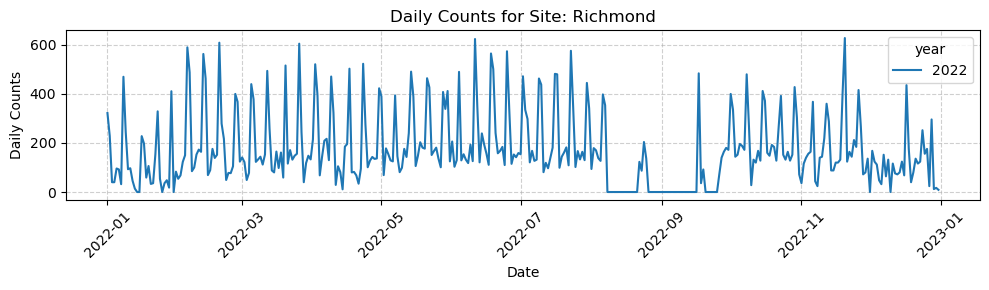

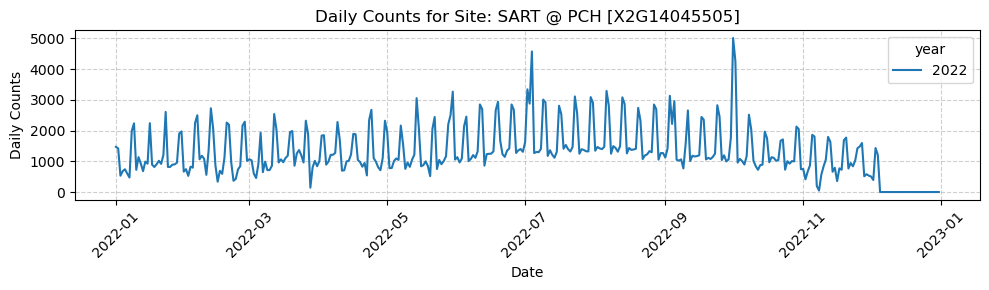

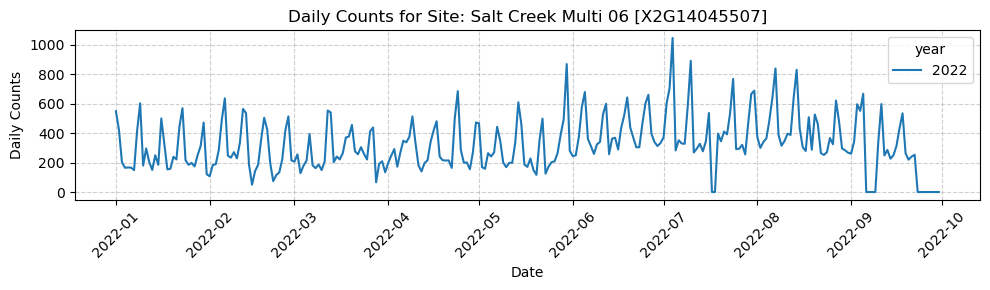

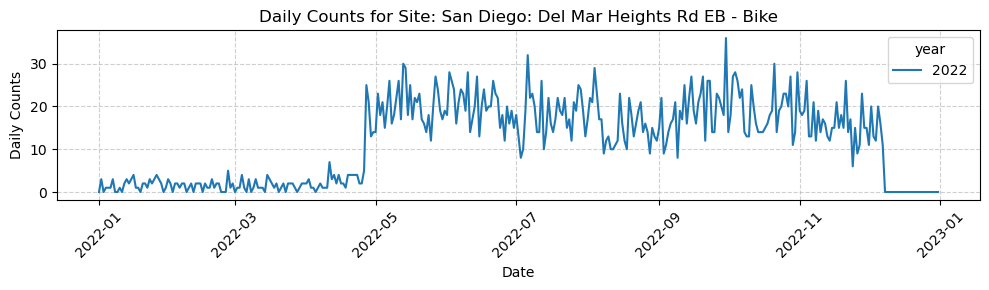

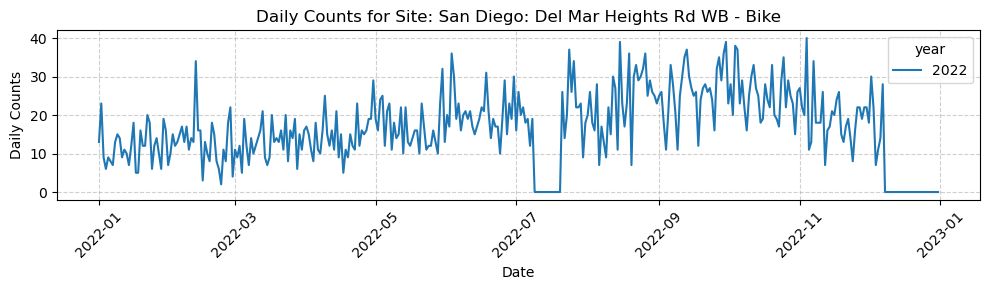

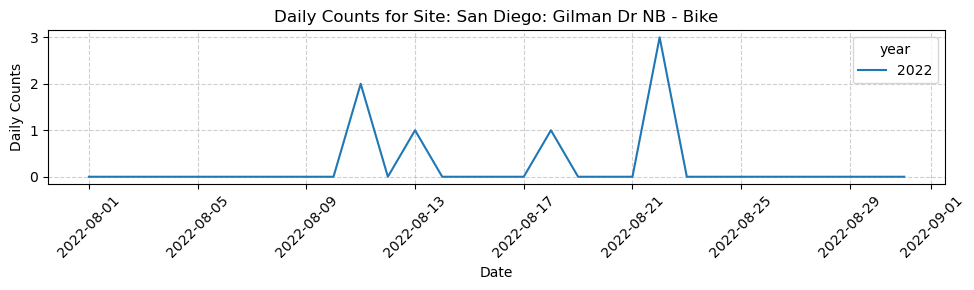

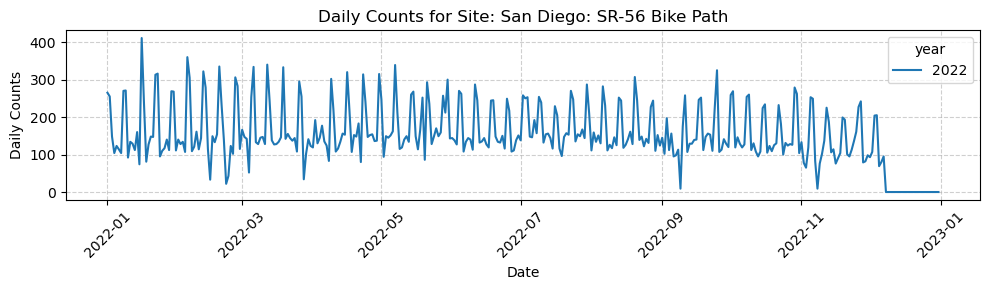

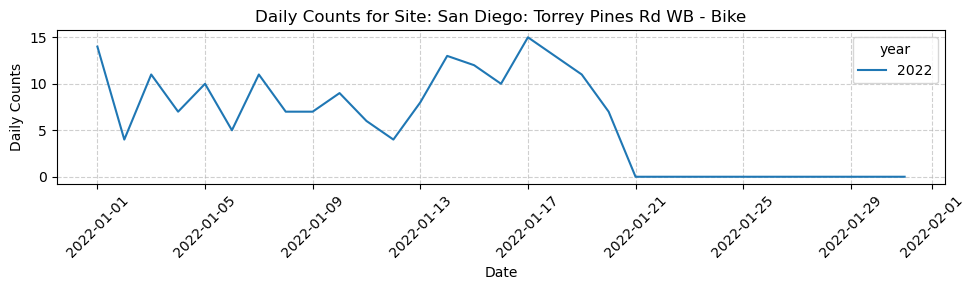

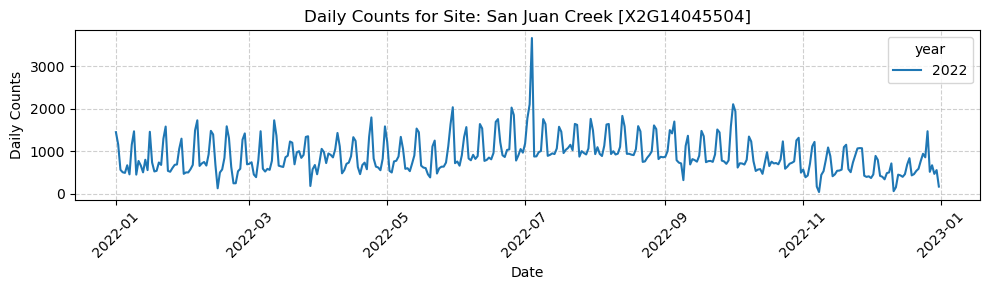

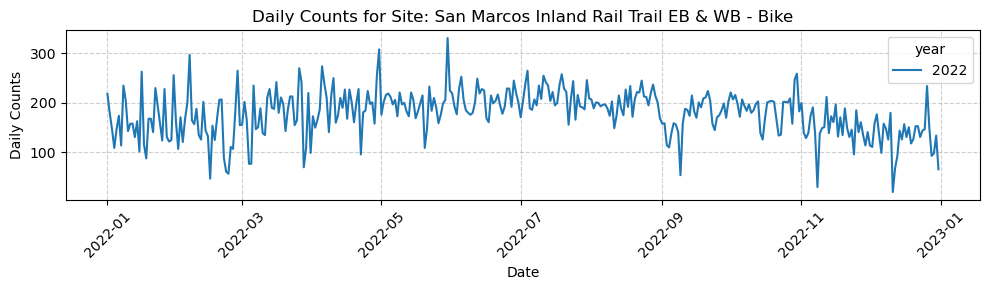

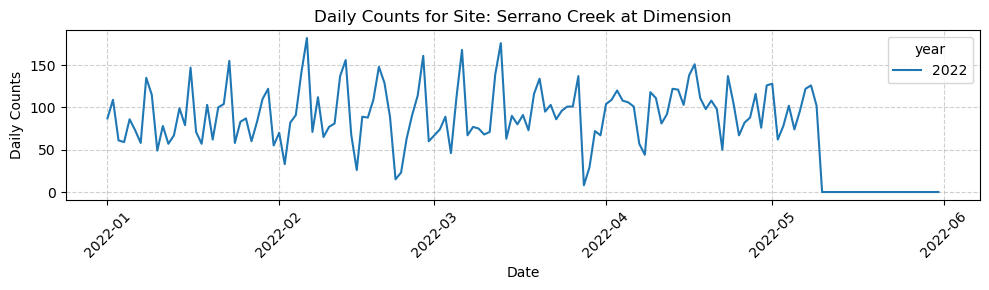

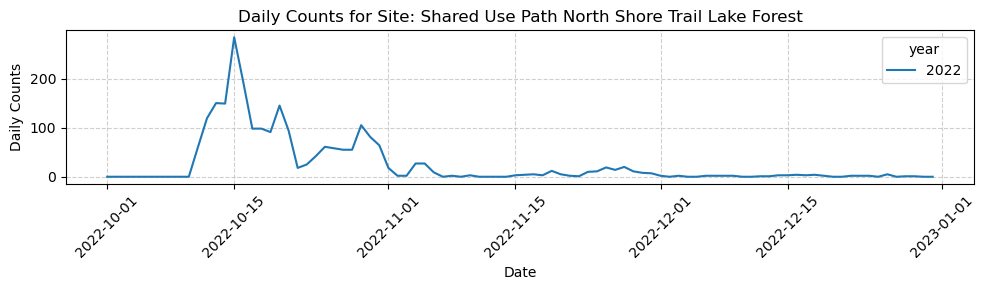

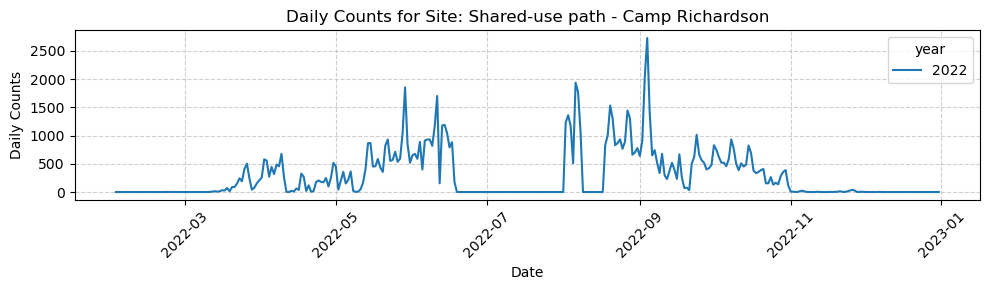

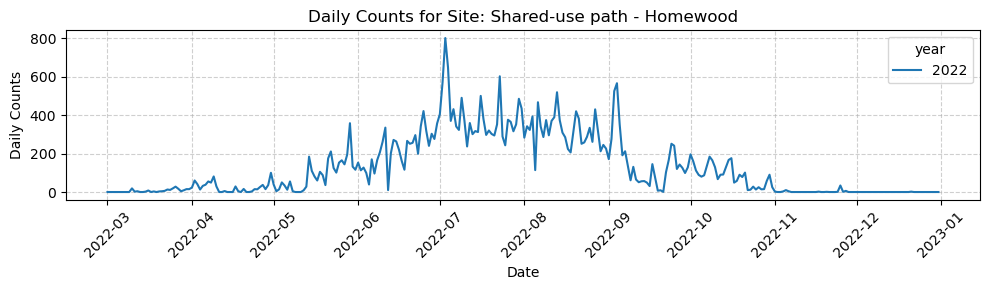

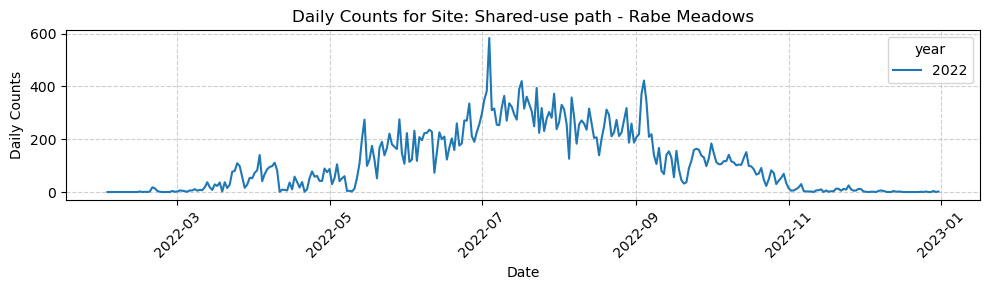

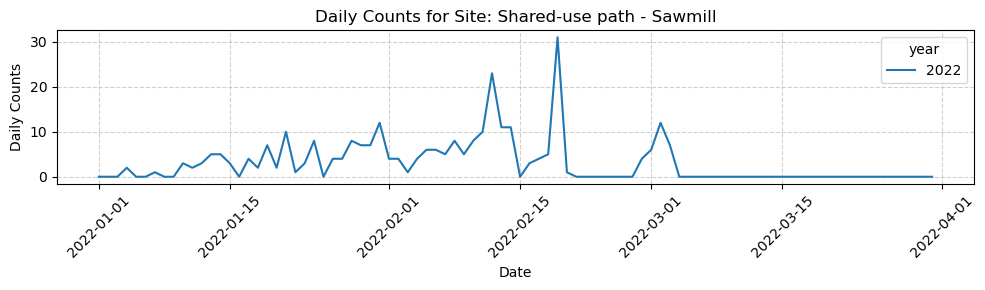

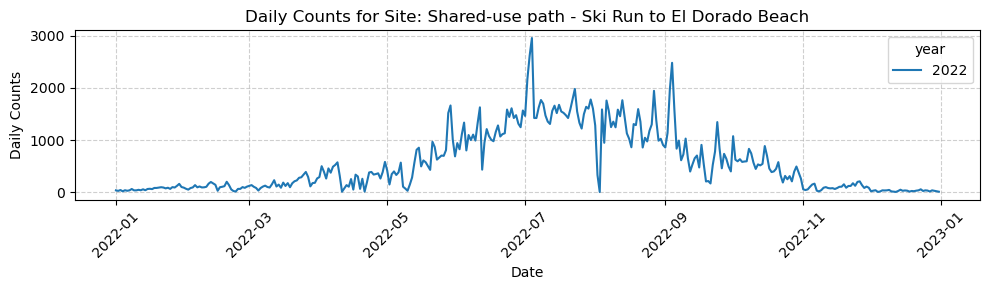

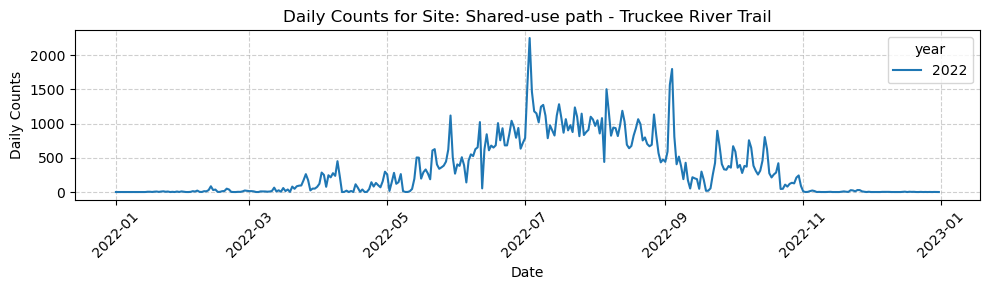

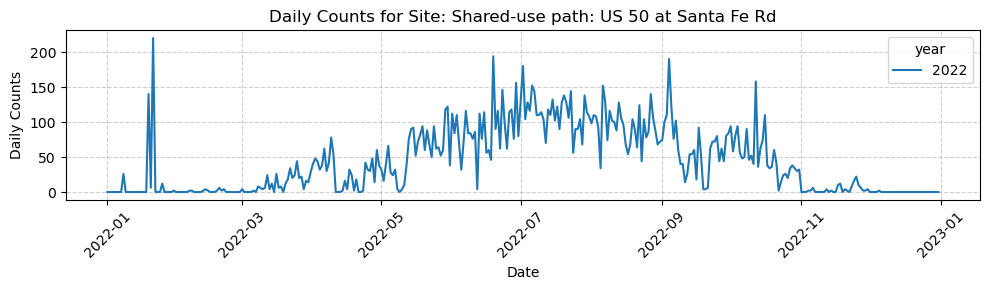

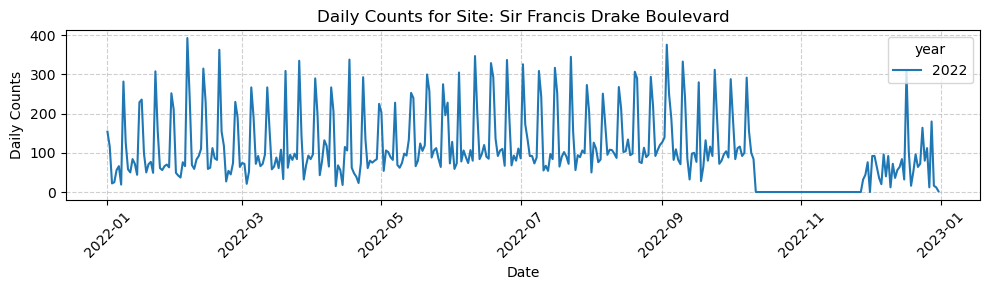

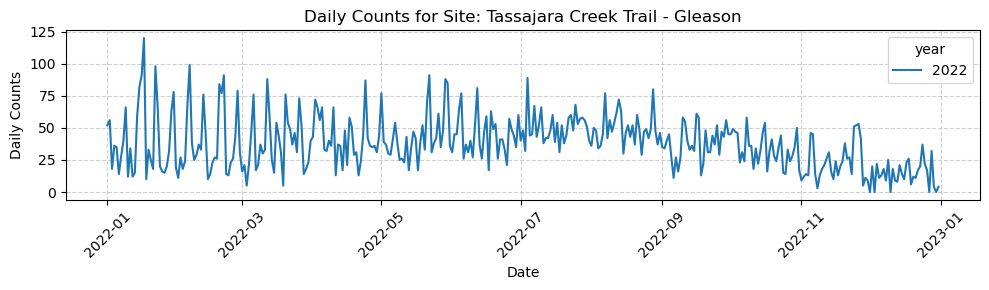

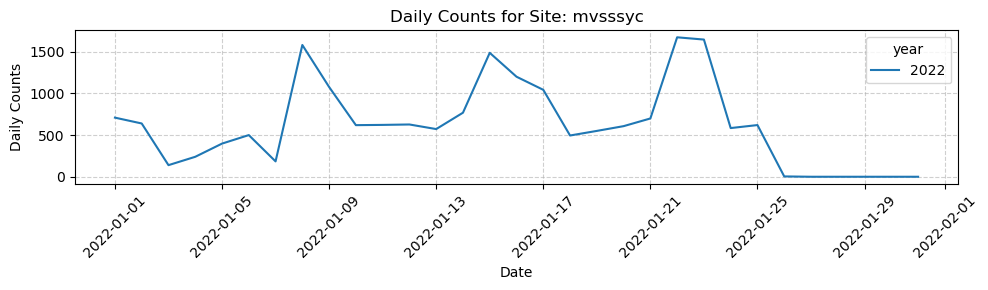

In [160]:
# Graph daily counts
graphing_data = hourly_total_count_clean_per_site_flagged.groupby(['site_name', 'year','Date']).agg({'counts': 'sum'}).reset_index()
unique_sites = graphing_data['site_name'].unique()

# Create a line graph for each site
for site in unique_sites:
    site_data = graphing_data[graphing_data['site_name'] == site]
    
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=site_data, x='Date', y='counts', hue='year', palette='tab10')
    
    plt.title(f"Daily Counts for Site: {site}", fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Daily Counts", fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

In [161]:
# Define cutoff dates
# cutoff_dates = {
#     "(18) Fell St. Between Scott & Divisadero": [("2022-01-25", None)],
#     "Lakeside-Harrison Cycle Track": [("2022-02-11", None)],
#     "Lakeside-Harrison Cycle Track": [("2022-10-14", None)]
# }

# # Apply date filters
# for site, periods in cutoff_dates.items():
#     for start, stop in periods:
#         start = pd.to_datetime(start).tz_localize(None)
#         stop = pd.to_datetime(stop).tz_localize(None) if stop else None
#         if stop:
#             hourly_bike_eco = hourly_total_count_clean_per_site[~((hourly_total_count_clean_per_site['site_name'] == site) & 
#                                               (hourly_total_count_clean_per_site['Date'].dt.tz_localize(None) > pd.to_datetime(start)) & 
#                                               (hourly_total_count_clean_per_site['Date'].dt.tz_localize(None) < pd.to_datetime(stop)))]
#         else:
#             hourly_bike_eco = hourly_total_count_clean_per_site[~((hourly_total_count_clean_per_site['site_name'] == site) & 
#                                               (hourly_total_count_clean_per_site['Date'].dt.tz_localize(None) > pd.to_datetime(start)))]

In [162]:
hourly_total_count_clean_per_site_flagged.head()

site_name       Date          Start Time  \
2160  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 00:00:00   
2161  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 01:00:00   
2162  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 02:00:00   
2163  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 03:00:00   
2164  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 04:00:00   

       latitude   longitude  counts stratum  year month     Day  hour  \
2160  37.772475 -122.414678    12.0    Path  2022   Apr  Friday     0   
2161  37.772475 -122.414678     1.0    Path  2022   Apr  Friday     1   
2162  37.772475 -122.414678     2.0    Path  2022   Apr  Friday     2   
2163  37.772475 -122.414678     2.0    Path  2022   Apr  Friday     3   
2164  37.772475 -122.414678     4.0    Path  2022   Apr  Friday     4   

      prev_hour_count   flag  
2160              NaN  False  
2161             12.0  False  
2162              1.0  False  
2163              2.0  False  
2164              2.0  False

In [163]:
hourly_bike_eco=hourly_total_count_clean_per_site_flagged

In [164]:
# number of counts in each hour of each day of the week of month of year
counts_per_hour = hourly_bike_eco.groupby(['site_name', 'year', 'month', 'Day', 'hour'])['counts'].count().reset_index()
counts_per_hour = counts_per_hour.rename(columns={'counts': 'num_counts_per_hour'})
# number of hours with at least one count for each day of week in each month - year 
# need at least 1 count per hour (of DOW of month of year) to count the hour as having data 
at_least_one_count_hours = counts_per_hour[counts_per_hour['num_counts_per_hour'] >= 1].reset_index(drop=True)
n_hours_w_at_least_1_count_by_DOW = at_least_one_count_hours.groupby(['site_name', 'year', 'month', 'Day']).agg(n_hours_at_least_1_count = ('num_counts_per_hour','count')).reset_index()
# days of week of month with 24 hours of (at least one) count
# need 24 hours of data to count the day as having data
full_24_hour_days = n_hours_w_at_least_1_count_by_DOW[n_hours_w_at_least_1_count_by_DOW['n_hours_at_least_1_count']==24].reset_index(drop=True)
n_days_w_24_hour_count = full_24_hour_days.groupby(['site_name', 'year', 'month']).agg(n_full_24_hour_days = ('Day','nunique')).reset_index()
# months with 7 days of 24 hours of (at least one) count
# need 7 days of 24 hours of data to count the month as having data
seven_day_months = n_days_w_24_hour_count[n_days_w_24_hour_count['n_full_24_hour_days']==7].reset_index(drop=True)
n_months_w_7_days = seven_day_months.groupby(['site_name', 'year']).agg(n_7_day_months = ('month','nunique')).reset_index()
#Limit to data with 12 months of 7 days of 24 hours of counts, these are long term site-years
eligible_m_s_y_data = n_months_w_7_days[n_months_w_7_days['n_7_day_months'] == 12].reset_index(drop=True)
eligible_m_s_y_data.head()

site_name  year  n_7_day_months
0        (01) 11th St. Between Howard & Folsom  2022              12
1     (02) 17th St. between Mission & Valencia  2022              12
2  (07) 7th Ave. Between Lawton & Kirkham - NB  2022              12
3  (07) 7th Ave. Between Lawton & Kirkham - SB  2022              12
4       (10) 8th St. Between Folsom & Harrison  2022              12

In [165]:
# Merge the DataFrames on 'id', 'site_name', and 'year'
hourly_bike_counts_info = hourly_bike_eco.merge(eligible_m_s_y_data[['site_name', 'year']], 
                                 on=['site_name', 'year'], 
                                 how='left', 
                                 indicator=True)

# Create the 'long_term' column based on the merge indicator
hourly_bike_counts_info['long_term'] = hourly_bike_counts_info['_merge'].apply(lambda x: 'long_term' if x == 'both' else 'short_term')

# Drop the merge indicator column
hourly_bike_counts_info = hourly_bike_counts_info.drop(columns=['_merge'])
longterm_hourly_bike_clean = hourly_bike_counts_info[hourly_bike_counts_info['long_term'] == 'long_term'].reset_index(drop=True)
shortterm_hourly_bike_clean = hourly_bike_counts_info[hourly_bike_counts_info['long_term'] == 'short_term'].reset_index(drop=True)

In [242]:
longterm_hourly_bike_clean.to_csv('cleaned_qualified_count_data_2022.csv')

In [166]:
longterm_hourly_bike_clean .shape,shortterm_hourly_bike_clean.shape

((481742, 14), (125411, 14))

In [173]:
longterm_hourly_bike_clean=longterm_hourly_bike_clean.rename(columns={'counts':'Count'})
longterm_hourly_bike_clean['stratum']=longterm_hourly_bike_clean['stratum'].replace({
    'Path ':'Path'
})
longterm_hourly_bike_clean.head()

site_name       Date          Start Time  \
0  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 00:00:00   
1  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 01:00:00   
2  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 02:00:00   
3  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 03:00:00   
4  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 04:00:00   

    latitude   longitude  Count stratum  year month     Day  hour  \
0  37.772475 -122.414678   12.0    Path  2022   Apr  Friday     0   
1  37.772475 -122.414678    1.0    Path  2022   Apr  Friday     1   
2  37.772475 -122.414678    2.0    Path  2022   Apr  Friday     2   
3  37.772475 -122.414678    2.0    Path  2022   Apr  Friday     3   
4  37.772475 -122.414678    4.0    Path  2022   Apr  Friday     4   

   prev_hour_count   flag  long_term  
0              NaN  False  long_term  
1             12.0  False  long_term  
2              1.0  False  long_term  
3              2.0  False  long_term  
4              2.0  False  long_term

In [201]:
longterm_hourly_bike_clean.site_name.nunique()

49

In [197]:
longterm_hourly_bike_clean.columns

Index(['site_name', 'Date', 'Start Time', 'latitude', 'longitude', 'Count',
       'stratum', 'year', 'month', 'Day', 'hour', 'prev_hour_count', 'flag',
       'long_term'],
      dtype='object')

In [207]:
meta_data=longterm_hourly_bike_clean[['site_name','year','stratum']].drop_duplicates(subset=['site_name','year','stratum'])
meta_data.shape

(49, 3)

In [208]:
# Split the data

In [209]:
# Step 1: Split each stratum into 80% (train/dev) and 20% (test/holdout)
def stratified_split(x, frac_test=0.2, seed=95829):
    test = x.sample(frac=frac_test, random_state=seed)   # 20% for test
    train = x.drop(test.index)                           # 80% for development
    return train, test

# Apply stratified split
train_list = []
test_list = []

for stratum, group in meta_data.groupby("stratum"):
    train_grp, test_grp = stratified_split(group, frac_test=0.2)
    train_list.append(train_grp)
    test_list.append(test_grp)

data_for_factor_development = pd.concat(train_list).reset_index(drop=True)  # 80%
holdout_data_for_test = pd.concat(test_list).reset_index(drop=True)        # 20%

print("Development (80%) size:", len(data_for_factor_development))
print("Test (20%) size:", len(holdout_data_for_test))


Development (80%) size: 39
Test (20%) size: 10


In [210]:
holdout_data_for_test.groupby(['stratum'])['stratum'].count()

stratum
Bike Lane              1
Bike Route             1
Path                   5
Separated Bike Lane    1
Trail                  2
Name: stratum, dtype: int64

In [211]:
data_for_factor_development.groupby(['stratum'])['stratum'].count()

stratum
Bike Lane               2
Bike Route              6
Path                   19
Separated Bike Lane     3
Trail                   9
Name: stratum, dtype: int64

# Task 4: Calculate the expansion factors from the clean count data

In [212]:
longterm_hourly_bike_clean.head()

site_name       Date          Start Time  \
0  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 00:00:00   
1  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 01:00:00   
2  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 02:00:00   
3  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 03:00:00   
4  (01) 11th St. Between Howard & Folsom 2022-04-01 1900-01-01 04:00:00   

    latitude   longitude  Count stratum  year month     Day  hour  \
0  37.772475 -122.414678   12.0    Path  2022   Apr  Friday     0   
1  37.772475 -122.414678    1.0    Path  2022   Apr  Friday     1   
2  37.772475 -122.414678    2.0    Path  2022   Apr  Friday     2   
3  37.772475 -122.414678    2.0    Path  2022   Apr  Friday     3   
4  37.772475 -122.414678    4.0    Path  2022   Apr  Friday     4   

   prev_hour_count   flag  long_term  
0              NaN  False  long_term  
1             12.0  False  long_term  
2              1.0  False  long_term  
3              2.0  False  long_term  
4              2.0  False  long_term

In [213]:
# Now apply the AADT and MADT function to calculate these two metrics
AADT, MADT = AASHTO_AADT(longterm_hourly_bike_clean)

In [214]:
AADT.head()

site_name     stratum  year   wt_count  \
0        (01) 11th St. Between Howard & Folsom        Path  2022  221084.00   
1     (02) 17th St. between Mission & Valencia  Bike Route  2022  274622.75   
2  (07) 7th Ave. Between Lawton & Kirkham - NB        Path  2022   53353.00   
3  (07) 7th Ave. Between Lawton & Kirkham - SB        Path  2022   44448.00   
4       (10) 8th St. Between Folsom & Harrison  Bike Route  2022  226254.00   

   days_Ct  AADT  
0      365   606  
1      365   752  
2      365   146  
3      365   122  
4      365   620

In [215]:
AADT.shape

(49, 6)

In [216]:
MADT.head()

site_name stratum  year month  wt_count  dm  \
0  (01) 11th St. Between Howard & Folsom    Path  2022   Apr   18159.0  30   
1  (01) 11th St. Between Howard & Folsom    Path  2022   Aug   21576.0  31   
2  (01) 11th St. Between Howard & Folsom    Path  2022   Dec   13341.0  31   
3  (01) 11th St. Between Howard & Folsom    Path  2022   Feb   15877.0  28   
4  (01) 11th St. Between Howard & Folsom    Path  2022   Jan   14575.0  31   

   MADT  
0   605  
1   696  
2   430  
3   567  
4   470

In [217]:
# Now lets calculate DOWOMIF
dowom_count=longterm_hourly_bike_clean.groupby(['site_name', 'stratum',
            'year', 'month','Date', 'Day'])['Count'].sum().reset_index()
dowom_count1=dowom_count.groupby(['site_name', 'stratum',
            'year', 'month', 'Day'])['Count'].mean().reset_index()
# lets join with AADT 
dowom_factor=pd.merge(dowom_count1,AADT, on=['site_name', 'stratum',
            'year'])
dowom_factor["DOWOMIF"]=dowom_factor['Count']/dowom_factor['AADT']
# Now average the factor by group
dowom_factor_avg=dowom_factor.groupby(['stratum','year', 'month', 'Day']).agg(
    DOWOMIF=('DOWOMIF', 'mean'),
    num_sites = ('site_name','nunique')
).reset_index()
dowom_factor_avg.head()

stratum  year month       Day   DOWOMIF  num_sites
0  Bike Lane  2022   Apr    Friday  1.045030          3
1  Bike Lane  2022   Apr    Monday  0.838277          3
2  Bike Lane  2022   Apr  Saturday  1.145014          3
3  Bike Lane  2022   Apr    Sunday  1.161151          3
4  Bike Lane  2022   Apr  Thursday  0.835962          3

In [218]:
dowom_factor_avg.groupby(['stratum','year'])['year'].count()

stratum              year
Bike Lane            2022    84
Bike Route           2022    84
Path                 2022    84
Separated Bike Lane  2022    84
Trail                2022    84
Name: year, dtype: int64

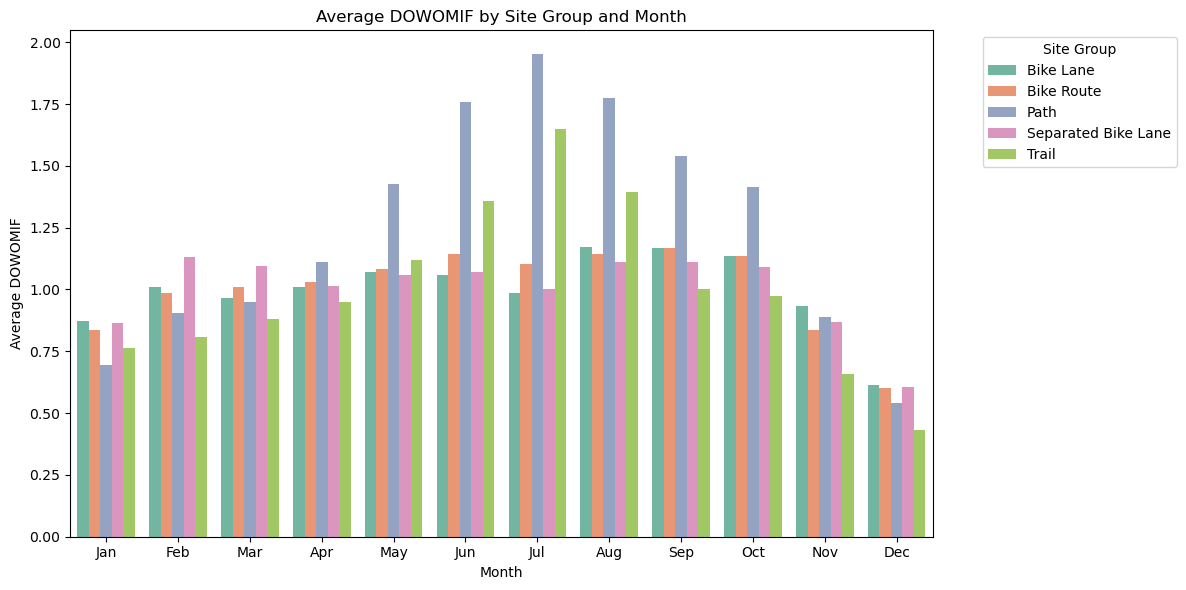

In [219]:
# Aggregate by Site_Group and month
dowomif_monthly_avg = dowom_factor_avg.groupby(['stratum', 'month'])['DOWOMIF'].mean().reset_index()

# Optional: set month order if not already in order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dowomif_monthly_avg['month'] = pd.Categorical(dowomif_monthly_avg['month'], categories=month_order, ordered=True)

# Sort for consistent plotting
dowomif_monthly_avg = dowomif_monthly_avg.sort_values(['month', 'stratum'])

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=dowomif_monthly_avg,
    x='month',
    y='DOWOMIF',
    hue='stratum',
    palette='Set2'
)

plt.title('Average DOWOMIF by Site Group and Month')
plt.xlabel('Month')
plt.ylabel('Average DOWOMIF')
plt.legend(title='Site Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [220]:
dowom_factor_avg.to_csv('C:/Undergraduate Research/draft_bike_facility_factor_DOWOM_Factor.csv')

# Task 5: Calculate the accuracy on holdout sites

In [221]:
# get the holdoutsite data
holdout_site_class=holdout_data_for_test[['site_name','year','stratum']]
holdout_longterm_hourly_bike_clean_data_with_group=pd.merge(longterm_hourly_bike_clean,holdout_site_class,on=['site_name','year','stratum'], how='inner')
holdout_longterm_hourly_bike_clean_data_with_group['week_of_year'] = pd.to_datetime(holdout_longterm_hourly_bike_clean_data_with_group['Date']).dt.isocalendar().week
holdout_longterm_hourly_bike_clean_data_with_group.head()

site_name       Date          Start Time  \
0  (07) 7th Ave. Between Lawton & Kirkham - NB 2022-04-01 1900-01-01 00:00:00   
1  (07) 7th Ave. Between Lawton & Kirkham - NB 2022-04-01 1900-01-01 01:00:00   
2  (07) 7th Ave. Between Lawton & Kirkham - NB 2022-04-01 1900-01-01 02:00:00   
3  (07) 7th Ave. Between Lawton & Kirkham - NB 2022-04-01 1900-01-01 03:00:00   
4  (07) 7th Ave. Between Lawton & Kirkham - NB 2022-04-01 1900-01-01 04:00:00   

   latitude  longitude  Count stratum  year month     Day  hour  \
0  37.75925 -122.46377    0.0    Path  2022   Apr  Friday     0   
1  37.75925 -122.46377    0.0    Path  2022   Apr  Friday     1   
2  37.75925 -122.46377    0.0    Path  2022   Apr  Friday     2   
3  37.75925 -122.46377    0.0    Path  2022   Apr  Friday     3   
4  37.75925 -122.46377    0.0    Path  2022   Apr  Friday     4   

   prev_hour_count   flag  long_term  week_of_year  
0              NaN  False  long_term            13  
1              0.0  False  long_term            13  
2              0.0  False  long_term            13  
3              0.0  False  long_term            13  
4              0.0  False  long_term            13

In [222]:
# Now apply the AADT and MADT function to calculate these two metrics
holdout_AADT, holdout_MADT = AASHTO_AADT(holdout_longterm_hourly_bike_clean_data_with_group)
holdout_AADT=holdout_AADT.rename(columns={'AADT':'Observed_AADT'})
holdout_AADT

site_name              stratum  year  \
0  (07) 7th Ave. Between Lawton & Kirkham - NB                 Path  2022   
1      (11) Arguello between Cabrillo & Fulton            Bike Lane  2022   
2     (18) Fell St. Between Scott & Divisadero  Separated Bike Lane  2022   
3                            East Bay Greenway                 Path  2022   
4               Iron Horse Trail - Owens Drive                Trail  2022   
5            La Mesa: University Ave WB - Bike           Bike Route  2022   
6                               PProm_McDowell                 Path  2022   
7                   San Diego: SR-56 Bike Path                 Path  2022   
8  San Marcos Inland Rail Trail EB & WB - Bike                Trail  2022   
9        Shared-use path: US 50 at Santa Fe Rd                 Path  2022   

        wt_count  days_Ct  Observed_AADT  
0   53353.000000      365            146  
1   51398.750000      365            141  
2  472923.416667      365           1296  
3   38343.000000      365            105  
4   38627.000000      365            106  
5    3051.000000      365              8  
6   26775.000000      365             73  
7   55729.000000      365            153  
8   65364.500000      365            179  
9    4032.500000      365             11

In [223]:
# combine all sites AADT and Save it
holdout_AADT1=holdout_AADT.rename(columns={'Observed_AADT':'AADT'})
All_Sites_AADT=pd.concat([AADT,holdout_AADT1],axis=0)
All_Sites_AADT.to_csv('C:/Undergraduate Research/All_Eligible_Sites_Bike_AADT.csv')

In [228]:
# Now imput the volume
dowom_count_test=holdout_longterm_hourly_bike_clean_data_with_group.groupby(['site_name', 'stratum',
            'year', 'month', 'Day','Date','week_of_year'])['Count'].sum().reset_index()
dowom_count_test1=dowom_count_test.groupby(['site_name', 'stratum',
            'year', 'month', 'Day','week_of_year'])['Count'].mean().reset_index()

imputed_aadt=pd.merge(dowom_count_test,dowom_factor_avg, on=['stratum','year', 'month', 'Day'],how='inner')
imputed_aadt['Imputed_AADT']=imputed_aadt['Count']/imputed_aadt['DOWOMIF']
imputed_aadt_ave=imputed_aadt.groupby(['site_name', 'stratum','year','week_of_year']).agg(Imputed_AADT=('Imputed_AADT','mean')).reset_index()
imputed_aadt_ave.head()

site_name stratum  year  week_of_year  \
0  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022             1   
1  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022             2   
2  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022             3   
3  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022             4   
4  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022             5   

   Imputed_AADT  
0     98.672602  
1    143.210687  
2    171.815465  
3    202.578985  
4    189.655163

In [225]:
imputed_aadt.groupby(['stratum'])['DOWOMIF'].describe()

count      mean       std       min       25%       50%  \
stratum                                                                         
Bike Lane             365.0  0.999033  0.176992  0.399528  0.908614  1.020148   
Bike Route            365.0  1.006300  0.200496  0.429669  0.886355  1.020236   
Path                 1825.0  1.247874  0.464893  0.454245  0.862764  1.325274   
Separated Bike Lane   365.0  0.999857  0.198832  0.324822  0.878349  0.999153   
Trail                 730.0  1.001604  0.394665  0.371479  0.692862  0.890347   

                          75%       max  
stratum                                  
Bike Lane            1.112250  1.377123  
Bike Route           1.146638  1.394190  
Path                 1.643621  2.237168  
Separated Bike Lane  1.155706  1.291665  
Trail                1.276040  1.978183

In [229]:
imputed_observed_AADT=pd.merge(holdout_AADT,imputed_aadt, on=['site_name','stratum','year'],how='inner')
imputed_observed_AADT.head()

site_name stratum  year  wt_count  \
0  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022   53353.0   
1  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022   53353.0   
2  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022   53353.0   
3  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022   53353.0   
4  (07) 7th Ave. Between Lawton & Kirkham - NB    Path  2022   53353.0   

   days_Ct  Observed_AADT month     Day       Date  week_of_year  Count  \
0      365            146   Apr  Friday 2022-04-01            13  163.0   
1      365            146   Apr  Friday 2022-04-08            14  172.0   
2      365            146   Apr  Friday 2022-04-15            15  170.0   
3      365            146   Apr  Friday 2022-04-22            16  172.0   
4      365            146   Apr  Friday 2022-04-29            17  188.0   

    DOWOMIF  num_sites  Imputed_AADT  
0  1.152549         24    141.425700  
1  1.152549         24    149.234481  
2  1.152549         24    147.499197  
3  1.152549         24    149.234481  
4  1.152549         24    163.116759

In [231]:
results = calculate_error_metrics(imputed_observed_AADT)

# Print summary statistics
print("MAPE:", results['MAPE'], "%")
print("RMSE:", results['RMSE'])
print("R²:", results['R2'])

MAPE: 50.49 %
RMSE: 139.4
R²: 0.8519


C:\Users\s160555\AppData\Local\anaconda3\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [232]:
metrics_df = imputed_observed_AADT.groupby(['stratum', 'year', 'month']).apply(compute_metrics).reset_index()
metrics_df.head()

C:\Users\s160555\AppData\Local\anaconda3\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\s160555\AppData\Local\anaconda3\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\s160555\AppData\Local\anaconda3\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\s160555\AppData\Local\anaconda3\envs\geo_env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: '

stratum  year month       MAPE       RMSE   R2
0  Bike Lane  2022   Apr  16.167155  31.060652  0.0
1  Bike Lane  2022   Aug  12.123843  28.295601  0.0
2  Bike Lane  2022   Dec  34.242922  65.063946  0.0
3  Bike Lane  2022   Feb  13.581310  24.021587  0.0
4  Bike Lane  2022   Jan  19.164516  33.734448  0.0

In [233]:
metrics_df.groupby(['stratum'])['RMSE'].describe()

count        mean         std         min         25%  \
stratum                                                                      
Bike Lane             12.0   28.390856   12.605460   18.019741   21.533654   
Bike Route            12.0    4.275290    1.637841    3.225041    3.461740   
Path                  12.0   49.124512   15.538043   34.129759   37.558076   
Separated Bike Lane   12.0  386.466689  165.328460  224.536745  262.459412   
Trail                 12.0   52.695200   24.871703   26.052198   41.402233   

                            50%         75%         max  
stratum                                                  
Bike Lane             26.243509   29.166303   65.063946  
Bike Route             3.697523    4.354818    9.204512  
Path                  43.202858   55.168174   82.344823  
Separated Bike Lane  319.960229  512.881911  670.792868  
Trail                 47.353512   53.606709  120.101902

In [234]:
metrics_df.groupby(['stratum'])['MAPE'].describe()

count       mean        std        min        25%  \
stratum                                                                  
Bike Lane             12.0  14.693702   6.857238   8.399512  10.691686   
Bike Route            12.0  42.226436  19.395995  31.050794  33.878548   
Path                  12.0  72.714535  27.660286  36.092220  51.871340   
Separated Bike Lane   12.0  24.634145  10.419367  15.108145  17.994144   
Trail                 12.0  29.063709  13.660495  15.955865  22.489732   

                           50%        75%         max  
stratum                                                
Bike Lane            13.524881  14.916124   34.242922  
Bike Route           36.349516  40.524740  102.385106  
Path                 70.828031  87.257794  118.669858  
Separated Bike Lane  19.878817  30.282871   45.204924  
Trail                26.522246  29.027899   66.763369

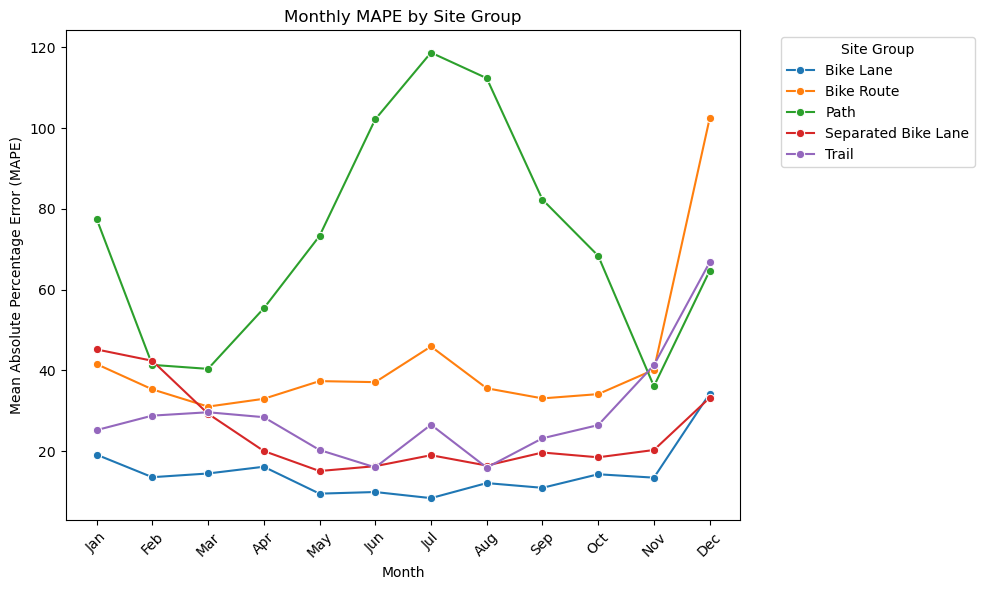

In [235]:
if metrics_df['month'].dtype == 'object':
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    metrics_df['month'] = pd.Categorical(metrics_df['month'], categories=month_order, ordered=True)

# ---- Step 2: Plot ----
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x='month', y='MAPE', hue='stratum', marker='o')
plt.title("Monthly MAPE by Site Group")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Site Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

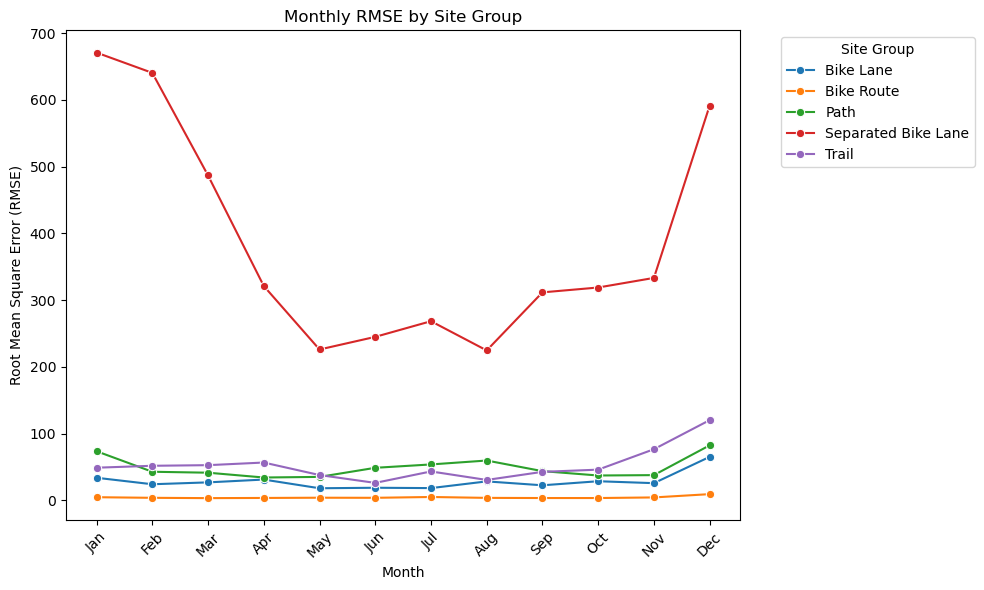

In [236]:
if metrics_df['month'].dtype == 'object':
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    metrics_df['month'] = pd.Categorical(metrics_df['month'], categories=month_order, ordered=True)

# ---- Step 2: Plot ----
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics_df, x='month', y='RMSE', hue='stratum', marker='o')
plt.title("Monthly RMSE by Site Group")
plt.ylabel("Root Mean Square Error (RMSE)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="Site Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

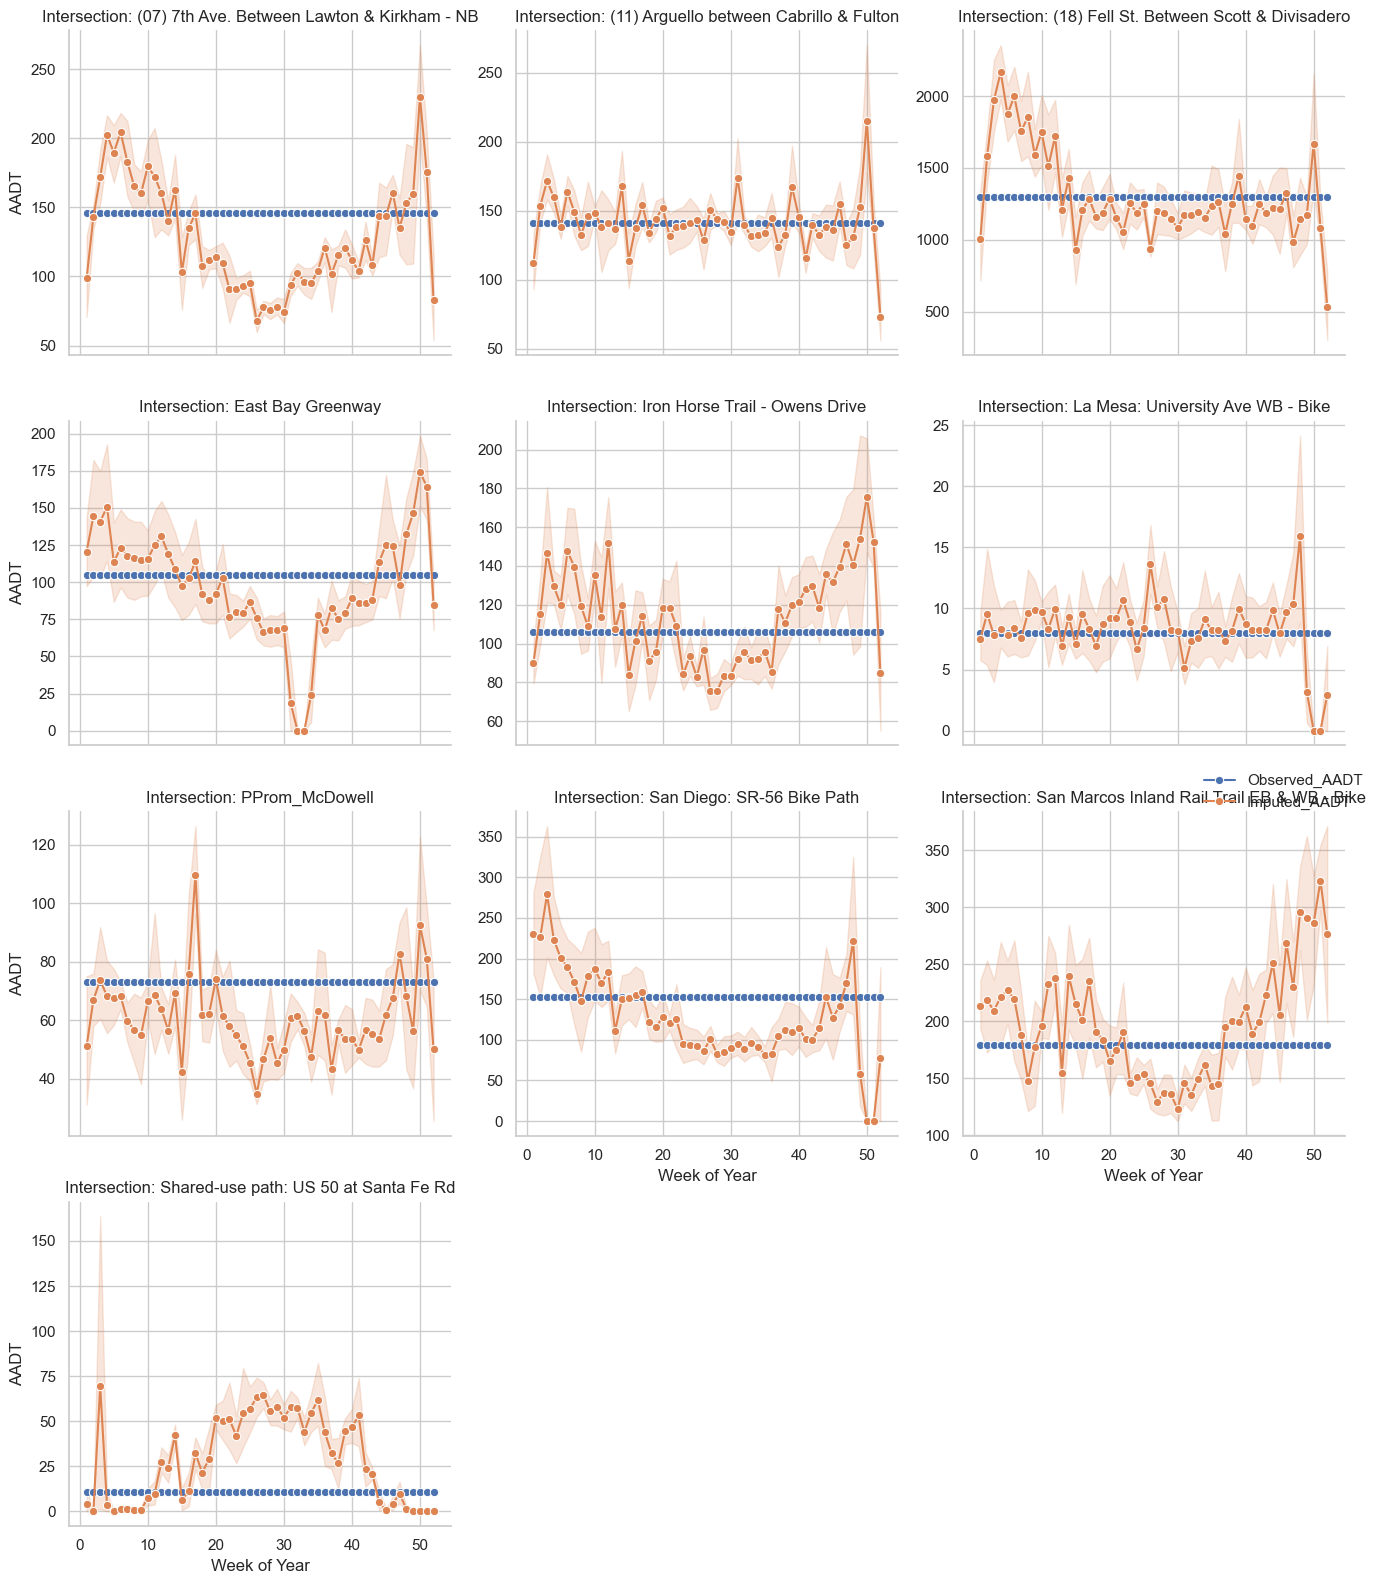

In [238]:
# Melt the DataFrame to long format for Seaborn
df_long = imputed_observed_AADT.melt(
    id_vars=['site_name', 'year','week_of_year'],
    value_vars=['Observed_AADT', 'Imputed_AADT'],
    var_name='Type',
    value_name='AADT'
)

# Set plot style
sns.set(style="whitegrid")

# Create FacetGrid with one subplot per Loc_id
g = sns.FacetGrid(df_long, col="site_name", col_wrap=3, height=4, sharey=False)

# Map lineplot onto each subplot
g.map_dataframe(sns.lineplot, x="week_of_year", y="AADT", hue="Type", marker="o")

# Improve legend and axis labels
g.add_legend()
g.set_axis_labels("Week of Year", "AADT")
g.set_titles("Intersection: {col_name}")
plt.tight_layout()
plt.show()

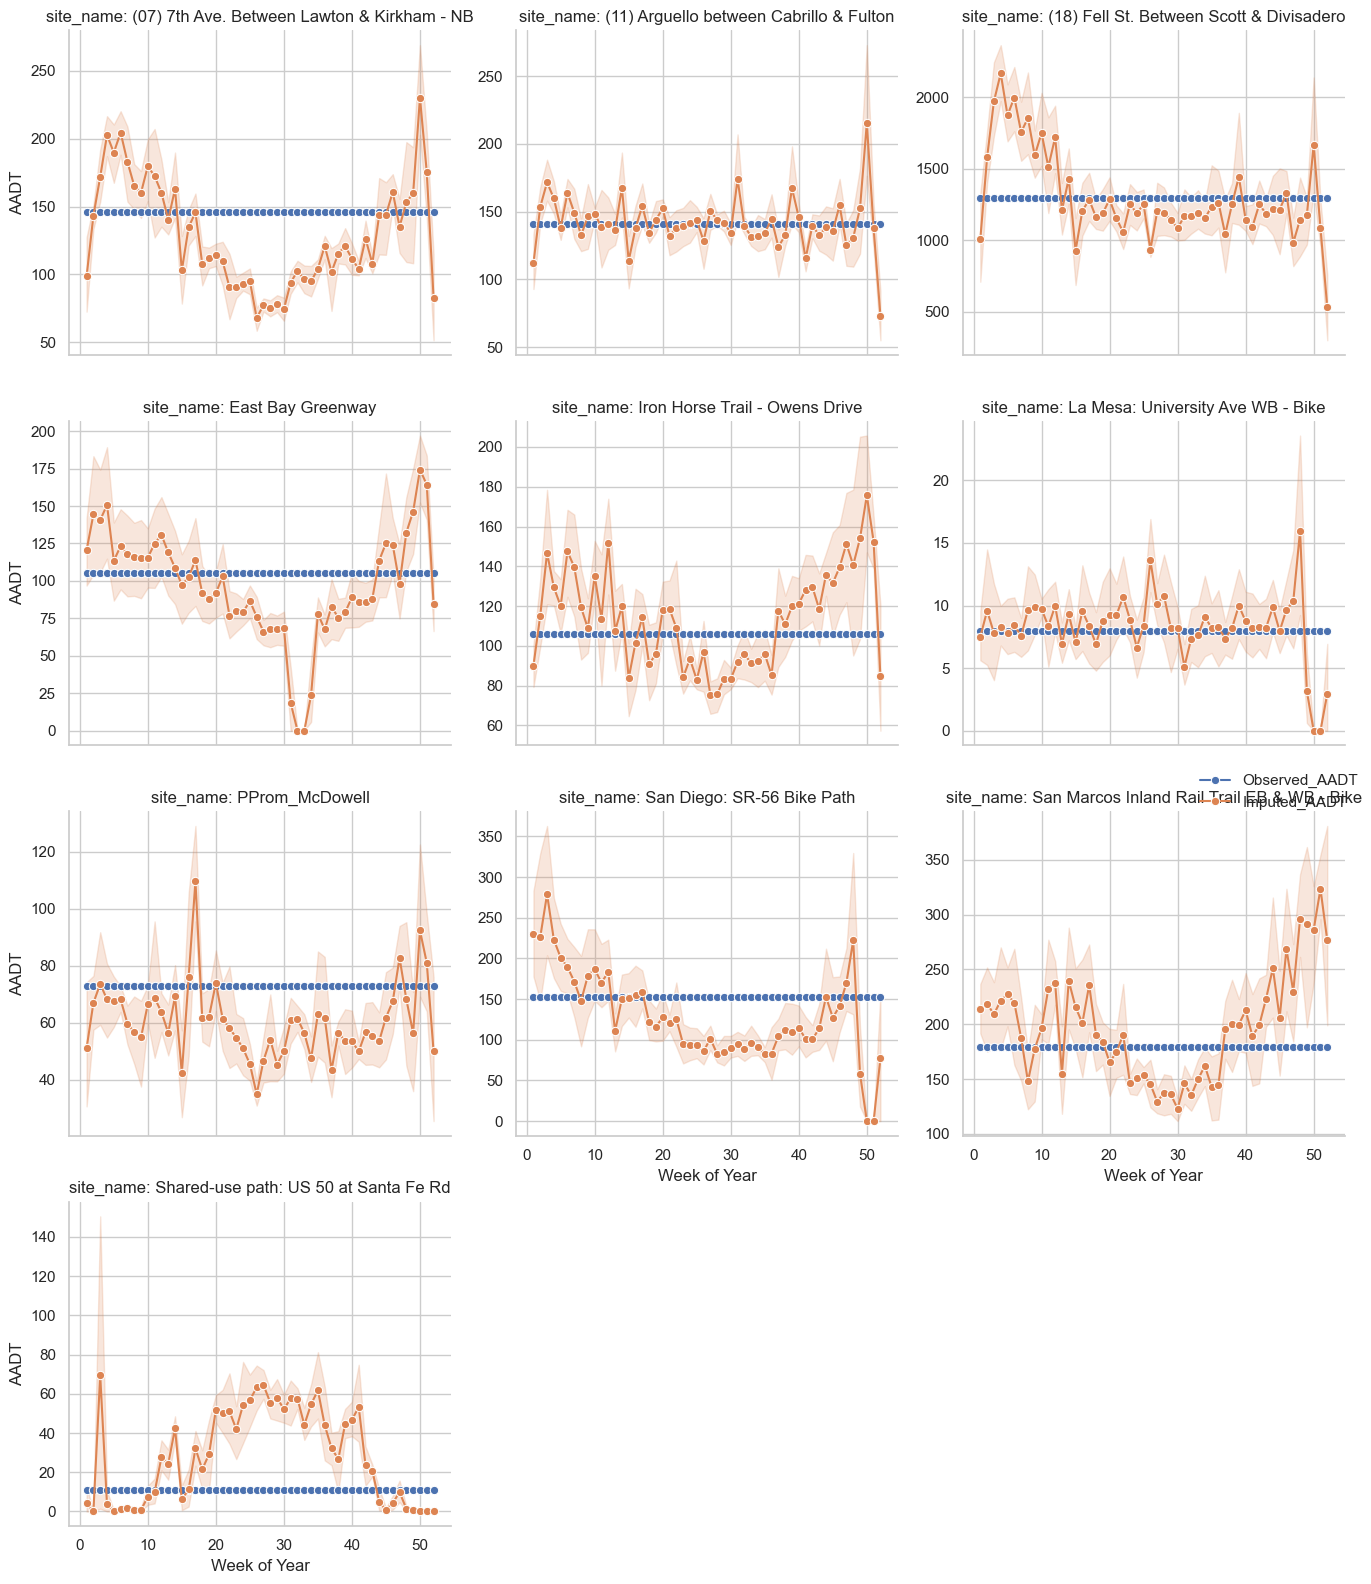

In [241]:
# Melt the DataFrame to long format for Seaborn
df_long = imputed_observed_AADT.melt(
    id_vars=['site_name','year', 'week_of_year'],
    value_vars=['Observed_AADT', 'Imputed_AADT'],
    var_name='Type',
    value_name='AADT'
)

# Set plot style
sns.set(style="whitegrid")

# Create FacetGrid with one subplot per Loc_id
g = sns.FacetGrid(df_long, col='site_name', col_wrap=3, height=4, sharey=False)

# Map lineplot onto each subplot
g.map_dataframe(sns.lineplot, x="week_of_year", y="AADT", hue="Type", marker="o")

# Improve legend and axis labels
g.add_legend()
g.set_axis_labels("Week of Year", "AADT")
g.set_titles("site_name: {col_name}")
plt.tight_layout()
plt.show()

# Task 6: Apply the Expansion Factors for short term sites

In [154]:
# without justfiying the accuracy of the developed factors, do not apply these factors for short term dites